# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import resin
import pandas as pd

import time 
import scipy.optimize 

from mpl_toolkits.mplot3d import Axes3D

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 06/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig06'

In [3]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'


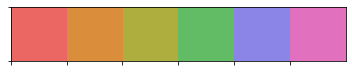

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

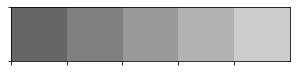

In [5]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


Plot-specific info

In [6]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [7]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

birds = ['Bird 1', 'Bird 2', 'Bird 3', 'Bird 4', 'Bird 5']

In [8]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Import per-epoch variables

In [9]:
# Recalculated -- in current version of manuscript
var_path = './Epoch-by-epoch_variables/'

## Path to detect SW ands EM events - using 1s epochs
events_path = '../data_copies/SWs_EMs_and_EMartifacts/1s-epochs/'

In [10]:
AllEpochs = pd.DataFrame([])


In [11]:
SleepVariables = {}

nEpochs = pd.Series([])
for file in np.sort(os.listdir(var_path)):
    if 'LL' not in file:
        if file.endswith('.csv'):
            data = pd.read_csv(var_path + file, index_col=0)
            ch = file.split('_')[0].split('.')[0]   # get name of channel from filename

            SleepVariables[ch] = data
            nEpochs.loc[ch] = len(data)
        
AllEpochs['nEpochs'] = nEpochs

# Remove artifacts based on max amplitude

In [12]:
# calculated using below code
channel_artifact_thres = {
'Bird 1: 4 LEEGf-Fgr' : 334.6614824230419,
'Bird 1: 5 LEEGf-LEEGp' : 279.2679036087251,
'Bird 1: 6 LEEGm-LEEGp' : 465.24488691372113,
'Bird 1: 7 LEEGp-Fgr' : 320.5607548553074,
'Bird 1: 8 REEGp-Fgr' : 357.8599664737276,
'Bird 1: 9 REEGp-LEEGp' : 372.9954559400473,
'Bird 2: 4 LEEGf-Fgr' : 504.72536588215985,
'Bird 2: 5 LEEGf-LEEGm' : 260.6034616921849,
'Bird 2: 6 LEEGm-LEEGp' : 248.599520730528,
'Bird 2: 7 REEGf-Fgr' : 524.3624990659733,
'Bird 2: 8 REEGm-Fgr' : 563.8844002322004,
'Bird 2: 9 REEGf-REEGm' : 415.4251751631489,
'Bird 3: 4LEEGf-LEEGp' : 434.3907547931754,
'Bird 3: 5LEEGf-LEEGm' : 570.3830657447792,
'Bird 3: 6LEEGm-LEEGp' : 431.8025000446411,
'Bird 3: 7REEGf-REEGp' : 682.6618564103704,
'Bird 3: 8REEGf-REEGm' : 630.2331039533059,
'Bird 3: 9REEGm-REEGp' : 565.1595695127436,
'Bird 4: 4LEEGf-LEEGp' : 326.9907988688425,
'Bird 4: 5LEEGm-LEEGp' : 229.17181995825953,
'Bird 4: 6LEEGm-LEEGf' : 305.3846764062442,
'Bird 4: 7REEGf-Fgr' : 236.09867154982518,
'Bird 4: 8REEGf-REEGm' : 4358.523887351811,
'Bird 4: 9REEGf-REEGp' : 390.99383856831656,
'Bird 5: 4LEEGf-LEEGp' : 362.4612557939865,
'Bird 5: 5LEEGf-LEEGm' : 328.4858836553137,
'Bird 5: 6LEEGm-LEEGp' : 364.33228858586614,
'Bird 5: 7REEGf-REEGp' : 307.9690407823895,
'Bird 5: 8REEGf-REEGm' : 454.4356898143054,
'Bird 5: 9REEGm-REEGp' : 451.1410894025525}

EEGdataAll = {}
TimeIndexEEG = {}
TimeIndexPower = {}

for b_num in birds: 
    
    b = int(b_num[5]) - 1   
        
##### arf files for all datasets except 4LL
    
    if '4LL' not in b_num:
    
        if 'LL' in b_num:
            arf_path = birdPaths_LL[b-1] + arfFilePaths_LL[b-1]
        else:
            arf_path = birdPaths[b] + arfFilePaths[b]

        for channel in channelsToLoadEEG[b]:
            all_data_array = np.array([])

            for file in np.sort(os.listdir(arf_path)):
                if file.endswith('.arf'):
                    arffile = h5py.File(arf_path+file, 'r')
                    data_array = arffile['.'][channel][()]
                    data_array = np.ndarray.flatten(data_array)

                    # Pad the end with NaN's to make it divisible by epoch length
                    nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
                    nanPadding.fill(np.nan)
                    data_array = np.append(data_array,nanPadding)   

                    all_data_array = np.append(all_data_array,data_array)

            # Do not reshape

            # Save in dict under bird number and channel
            data_name = b_num + ': ' + channel
            EEGdataAll[data_name] = scalingFactor * all_data_array
    
##### bark files for 4LL

    elif '4LL' in b_num:
        if 'LL' in b_num:
            arf_path = birdPaths_LL[b-1] + arfFilePaths_LL[b-1]
        else:
            arf_path = birdPaths[b] + arfFilePaths[b]
        
        for channel in channelsToLoadEEG_best[b]:
            all_data_array = np.array([])

            for file in np.sort(os.listdir(arf_path)):
                if file.endswith('.dat'):
                    dset = bark.read_sampled(arf_path + file)

                    # get channel number
                    ch_num = [x for x in dset.attrs['columns'].keys() if channel in dset.attrs['columns'][x]['channel_name']]
                    if len(ch_num) != 1:
                        print("for bird", b_num, "channel", channel, ": correct number of channels not found")

                    data_array = dset.data[:, ch_num]
                    data_array = np.array(np.ndarray.flatten(data_array))  # flatten and take out of memmap modes

                    # Pad the end with NaN's to make it divisible by epoch length
                    nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
                    nanPadding.fill(np.nan)
                    data_array = np.append(data_array,nanPadding)   

                    all_data_array = np.append(all_data_array,data_array)

                # Do not reshape

                # Save in dict under bird number and channel
                data_name = b_num + ': ' + channel
                EEGdataAll[data_name] = scalingFactor * all_data_array
    
##### Create time index for EEG

    all_time_array = np.array([], dtype='datetime64')
    for file in np.sort(os.listdir(arf_path)):
        if file.endswith('.arf')|file.endswith('.dat'):

            date = file.split('_')[2]

            if (b == 0) & ('2014-10-17' in file):
                hours = '17'
                minutes = '32'
            elif b == 0:
                hours = '09'
                minutes = '00'
            else:
                time_ = file.split('_')[3].split('.')[0]
                hours = time_.split('-')[0]
                minutes = time_.split('-')[1]

            datetime_start = np.datetime64(date + 'T' + hours + ':' + minutes + ':06')    # assume 6-s delay in starting recording

            # time index in datetime format
            
            if file.endswith('.arf'):
                arffile = h5py.File(arf_path+file, 'r')
                length_pts   = len(arffile['.'][channel][()])
            elif file.endswith('.dat'):
                length_pts   = len(bark.read_sampled(arf_path + file).data[:,0])
            
            padding_pts = epochLengthPts - np.mod(length_pts, epochLengthPts)
            length_s = (length_pts+padding_pts)/sr
            length_ms = np.timedelta64(int(1000 * length_s), 'ms')
            datetime_end = datetime_start + length_ms

            time_array = np.arange(datetime_start, datetime_end, np.timedelta64(int(1000/sr),'ms')) 

            # Add to end of whole-night time index
            all_time_array = np.append(all_time_array, time_array)


    
    TimeIndexEEG[b_num] = all_time_array
    
    # Get time at the start of each epoch
    TimeIndexPower[data_name] = all_time_array[np.arange(0,len(all_time_array),epochLengthPts)]
    

EEGchannels = np.sort(list(EEGdataAll.keys()))

# Set thresholds
artifact_threshold_SD  = 4   # of SDs away from mean

channel_artifact_thres = pd.Series([]) # init

for ch in EEGchannels:
    data = EEGdataAll[ch]

    # mean + N*SD
    artifact_threshold_SD_uV = (data[~np.isnan(data)]).mean() + artifact_threshold_SD*(data[~np.isnan(data)]).std()
    print(ch + ' : ' + str(artifact_threshold_SD_uV))
          
    # Save to dataframe
    channel_artifact_thres.loc[ch] = artifact_threshold_SD_uV
    

In [13]:
nEpochs_remaining = pd.Series([])
for ch in SleepVariables.keys():
    ChannelVariables = SleepVariables[ch].copy()
    
    # pull out only sleep rows
    sleep_data = ChannelVariables[ChannelVariables["is sleep"]==1]
    amp_thres = channel_artifact_thres[ch]
    
    # remove epochs with a max amplitude exceeding the threshold
    sleep_data = sleep_data[np.abs(sleep_data['max amp']) < amp_thres]
    
    SleepVariables[ch] = sleep_data
    
    # Calc number of epochs remaining
    nEpochs_remaining.loc[ch] = len(sleep_data)
        
AllEpochs['nEpochs w/o max amp'] = nEpochs_remaining

# Dump EEG data so it's not staying in memory
EEGdataAll = None

### calc % of epochs removed

In [14]:
EEGchannels = np.sort(list(SleepVariables.keys()))

EEGchannels_LD = [x for x in EEGchannels if 'LL' not in x]

AllEpochs = AllEpochs.loc[EEGchannels_LD]
print('mean % epochs removed by max amp cutoff')
perc_ep_rm = 100*(AllEpochs['nEpochs'] - AllEpochs['nEpochs w/o max amp'])/AllEpochs['nEpochs']
print(np.mean(perc_ep_rm), '%  +/-', np.std(perc_ep_rm))

mean % epochs removed by max amp cutoff
4.0516016185362105 %  +/- 3.4325632021179606


# Calculate moving averages

In [15]:
figsize = (16,6)
figsize_smaller = (6,8)
axis_label_fontsize = 24

# Dot formatting
alpha_main = 0.2
alpha_darker = 0.3


# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

## FIGURE 06A: Smoothed delta, autocorrelations

In [16]:
# The channel shown in Figure 6A-B is 'Bird 3 - 9REEGm-REEGp'
ch = 'Bird 3: 9REEGm-REEGp'

In [17]:
variables = ["DeltaLog", "GammaDeltaRatio", "nPeaks"]
bird_scores = SleepVariables[ch]["sleep scores"]
b = int(ch[5]) - 1

###### X LIMITS FOR FIGURE 6B - shaded regions on 6A
x_ranges = np.array([[3.2, 3.3],
                     [8.9, 9.0]]) # in hours from the beginning of the night

x_range_s = x_ranges*3600 + lightsOffSec[b]

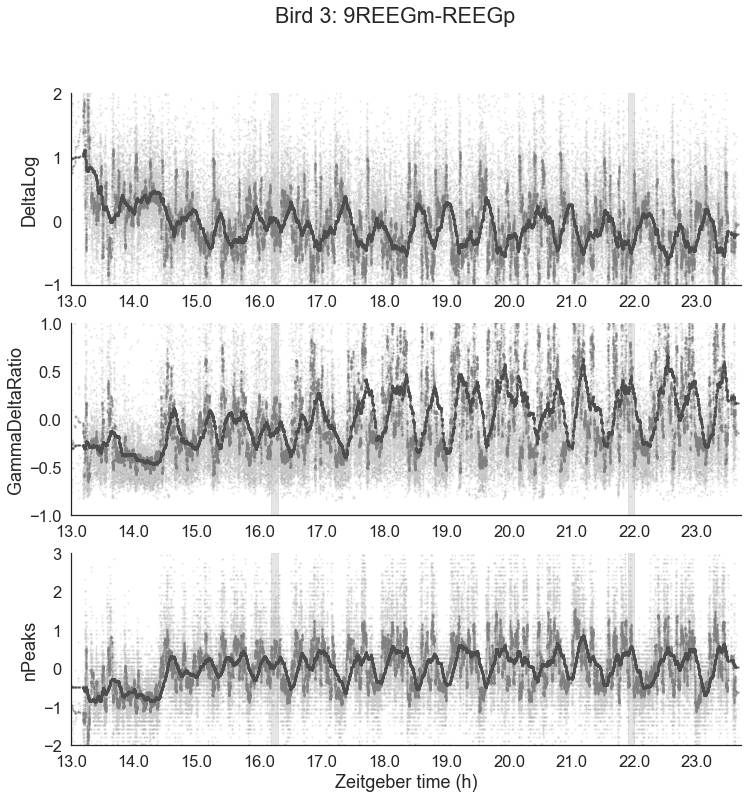

In [18]:
plt.figure(figsize=(12,12))
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    tmp_indSleep = np.array([x for x in bird_scores.index if (bird_scores[x]==3)|(bird_scores[x]==4)|(bird_scores[x]==5)])
    data = SleepVariables[ch][variable]
    data = data.loc[tmp_indSleep].dropna()
    
    # z-score & return to a Series
    data = pd.Series(stat.zscore(data), index=data.index)

    ## Plot
    plot_color = [.7, .7, .7]
    color1 = [.8, .8, .8]
    color2 = [.5, .5, .5]
    color3 = [.3, .3, .3]
    plt.plot(data, '.', color=plot_color, alpha=alpha_main, markersize=2.5)
    plt.plot(data.rolling(10, min_periods=1).mean(), '.', color=color1, alpha=alpha_darker, markersize=2.5)
    plt.plot(data.rolling(1*60, min_periods=1).mean(), '.', color=color2, alpha=alpha_darker, markersize=2.5)
    plt.plot(data.rolling(10*60, min_periods=1).mean(), '.', color=color3, alpha=alpha_darker, markersize=2.5)
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))

    plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],1*3600), np.arange(np.floor(lightsOffZeit_hr[b]) + 24,24,1))

    if variable == 'DeltaLog':
        plt.ylim((-1, 2))
    elif variable == 'GammaDeltaRatio':
        plt.ylim((-1, 1))
    else:
        plt.ylim((-2, 3))

        
    plt.ylabel(variable)
    
    row += 1
    sns.despine()
    
    # shade in areas to zoom in on later
    for x_range in x_range_s:
        plt.axvspan(x_range[0], x_range[1], color=color1, alpha=0.5)
        
plt.xlabel('Zeitgeber time (h)')
plt.suptitle(ch)
    
if savePlots:
    name = saveAsPath + saveAsName + 'a_10s1m10m_movingavg_' + ch
    plt.savefig(name + '.tiff', dpi=300)

## zoomed in

in Bird 3: the fast rhythm had a period of 40.8 s

In [19]:
6*60/40

9.0

### FIGURE 6B: background colored by stage

#### earlier in night

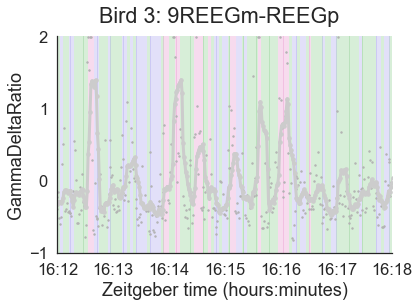

In [20]:
variables=["GammaDeltaRatio"]

bird_scores = SleepVariables[ch]["sleep scores"]
b = int(ch[5]) - 1

#x_range_hrs = np.array([6.1, 6.2])
#x_range_hrs = np.array([8.9, 9.0]) # in hours from the beginning of the night
x_range_hrs = x_ranges[0]
x_range_s = x_range_hrs*3600 + lightsOffSec[b]

plt.figure(figsize=(6,4))  
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    tmp_indSleep = np.array([x for x in bird_scores.index if (bird_scores[x]==3)|(bird_scores[x]==4)|(bird_scores[x]==5)])
    data = SleepVariables[ch][[variable, 'sleep scores']]
    data = data.loc[tmp_indSleep].dropna()
    
    # z-score & return to a Dataframe w/ corresponding sleep scores
    z_data = pd.DataFrame(stat.zscore(data[variable]), index=data.index, columns=[variable])
    z_data['sleep scores'] = data['sleep scores']

    ## Plot
    plot_color = [.7, .7, .7]
    color1 = [.8, .8, .8]
    color2 = [.5, .5, .5]
    color3 = [.3, .3, .3]
    
    for stage in [3,4,5]:
        stage_data = z_data[z_data['sleep scores']==stage]
        plt.vlines(stage_data.index, ymin=-5, ymax=5, color=colors[stage], alpha=.25, linewidth=1)
        
        
    # Plot raw data as dots; data above ymax should appear on top edge of graph
    ymax = 2
    data_cutoff = z_data[variable].copy()
    data_cutoff[data_cutoff>ymax] = ymax
    plt.plot(data_cutoff, '.', color=plot_color, alpha=.9, markersize=3)
    
    # Plot 10-s rolling mean as solid line
    plt.plot(z_data[variable].rolling(10, min_periods=1).mean(), '.-', color=color1, markersize=7,
             linewidth=3)

    plt.xlim((lightsOffSec[b],lightsOnSec[b]))

    # get x-axis labels in HH:MM
    label_freq_s = 60
    
    time_index_s = pd.Series(np.arange(0, 24*3600, label_freq_s)) + 3600*(np.floor(lightsOffZeit_hr[b])+24)
    def convert(seconds): 
        return time.strftime("%H:%M", time.gmtime(seconds)) 
    time_index_hhmm = time_index_s.apply(convert)

    plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],label_freq_s),
               time_index_hhmm)

    # other plot formatting
    plt.ylim((-1, ymax+.01))        
        
    plt.ylabel(variable)
    
    plt.xlim(tuple(x_range_s))
    
    row += 1
    sns.despine()
    
plt.xlabel('Zeitgeber time (hours:minutes)')
plt.suptitle(ch)
    
if savePlots:
    name = saveAsPath + saveAsName + 'b-early_10s1m10m_movingavg_zoomedin_' + ch
    plt.savefig(name + '.tiff', dpi=300)
    plt.savefig(name + '.pdf', dpi=300)
    

#### later in night

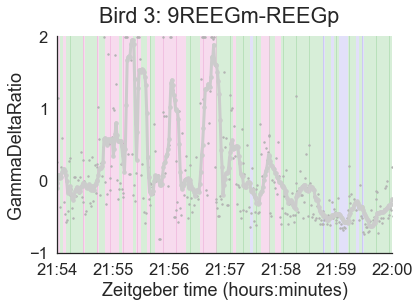

In [21]:
variables=["GammaDeltaRatio"]

bird_scores = SleepVariables[ch]["sleep scores"]
b = int(ch[5]) - 1

#x_range_hrs = np.array([6.1, 6.2])
#x_range_hrs = np.array([8.9, 9.0]) # in hours from the beginning of the night
x_range_hrs = x_ranges[1]
x_range_s = x_range_hrs*3600 + lightsOffSec[b]

plt.figure(figsize=(6,4))  
row = 1
for variable in variables:
    plt.subplot(len(variables),1,row)
    tmp_indSleep = np.array([x for x in bird_scores.index if (bird_scores[x]==3)|(bird_scores[x]==4)|(bird_scores[x]==5)])
    data = SleepVariables[ch][[variable, 'sleep scores']]
    data = data.loc[tmp_indSleep].dropna()
    
    # z-score & return to a Dataframe w/ corresponding sleep scores
    z_data = pd.DataFrame(stat.zscore(data[variable]), index=data.index, columns=[variable])
    z_data['sleep scores'] = data['sleep scores']

    ## Plot
    plot_color = [.7, .7, .7]
    color1 = [.8, .8, .8]
    color2 = [.5, .5, .5]
    color3 = [.3, .3, .3]
    
    for stage in [3,4,5]:
        stage_data = z_data[z_data['sleep scores']==stage]
        plt.vlines(stage_data.index, ymin=-5, ymax=5, color=colors[stage], alpha=.25, linewidth=1)
        
    # Plot raw data as dots; data above ymax should appear on top edge of graph
    ymax = 2
    data_cutoff = z_data[variable].copy()
    data_cutoff[data_cutoff>ymax] = ymax
    plt.plot(data_cutoff, '.', color=plot_color, alpha=.9, markersize=3)
    
    # Plot 10-s rolling mean as solid line
    plt.plot(z_data[variable].rolling(10, min_periods=1).mean(), '.-', color=color1, markersize=7,
             linewidth=3)
        
    plt.xlim((lightsOffSec[b],lightsOnSec[b]))

    # get x-axis labels in HH:MM
    label_freq_s = 60
    
    time_index_s = pd.Series(np.arange(0, 24*3600, label_freq_s)) + 3600*(np.floor(lightsOffZeit_hr[b])+24)
    def convert(seconds): 
        return time.strftime("%H:%M", time.gmtime(seconds)) 
    time_index_hhmm = time_index_s.apply(convert)

    plt.xticks(np.arange(np.floor(lightsOffSec[b]*3600)/3600,lightsOnSec[b],label_freq_s),
               time_index_hhmm)

    # other plot formatting
    plt.ylim((-1, ymax+.01))        
        
    plt.ylabel(variable)
    
    plt.xlim(tuple(x_range_s))
    
    row += 1
    sns.despine()
    
plt.xlabel('Zeitgeber time (hours:minutes)')
plt.suptitle(ch)
    
if savePlots:
    name = saveAsPath + saveAsName + 'b-late_10s1m10m_movingavg_zoomedin_late_' + ch
    plt.savefig(name + '.tiff', dpi=300)
    plt.savefig(name + '.pdf', dpi=300)
    

# Autocorrelation: FIG 06C-D DATA

The original will be slightly different from the recalculated version,

possibly due to changes in pandas/numpy/scipy
since the original Figure 6 was made in 2017

## period_from_autocorr

In [22]:
import statsmodels.tsa.stattools
import csv

# Make folder to save CSVs to
if not os.path.exists(saveAsPath + 'Fig8_data/'):
    os.mkdir(saveAsPath + 'Fig8_data/')

In [23]:
def period_from_autocorr(variable, b):
    
    birdToRun = 'Bird ' + str(b+1)
    all_channels = list(SleepVariables.keys())
    EEGchannels = np.sort([x for x in all_channels if birdToRun + ': ' in x])

    plt.figure(figsize=(6,16))
    
    # Make variable-specific folder
    if not os.path.exists(saveAsPath + 'Fig8_data/' + variable + '/'):
        os.mkdir(saveAsPath + 'Fig8_data/' + variable + '/')
    
    # save values of the first autocorrelation peak to a CSV file & to a dataframe
    output_filename = saveAsPath + 'Fig8_data/' + variable + '/' + saveAsName + birdToRun + '_firstpeaks_autocorr.csv'
    autocorr_peaks = pd.DataFrame([], index=['10s_MA', '1min_MA', '10min_MA']) # init dataframe
    with open(output_filename, 'w') as csvfile:
        # CSV writer object
        writer = csv.writer(csvfile, quoting=csv.QUOTE_NONE)
        # write header line
        writer.writerow( ['Channel', '10s_MA', '1min_MA', '10min_MA']) 

        row = 1
        for ch in EEGchannels:
            if 'EEG' in ch:
                # get channel-specific scores which are parsed into 1-s epochs and should not include artifacts > 4*SD
                bird_scores = SleepVariables[ch]["sleep scores"]
                
                tmp_indSleep = np.array([x for x in bird_scores.index if (bird_scores[x]==3)|(bird_scores[x]==4)|(bird_scores[x]==5)])
                data = SleepVariables[ch].loc[tmp_indSleep]
                
                
                # Get only sleep in the night
                data = data[(data['Epoch']>=(lightsOffEp[b]))&
                            (data['Epoch']<=(lightsOnEp[b]))]
                
                # Get variable of interest
                data = data[variable].dropna()
    
                # z-score & return to a Series
                data = pd.Series(stat.zscore(data), index=data.index)
            
                
                MA_window = 10
                moving_avg = data.rolling(MA_window, min_periods=1).mean()
                autocorr = statsmodels.tsa.stattools.acf(moving_avg, unbiased=True, nlags = 90*60)
                indsPeaks = sig.argrelmax(autocorr, order=1)[0]
                indsPeaks = indsPeaks[indsPeaks>MA_window] # the peak cannot be at a period smaller than the size of the moving average window
                indsPeaks = indsPeaks[autocorr[indsPeaks]>0] # the peak has to be positive
                plt.subplot(len(EEGchannels),1,row)
                plt.plot(autocorr, color=color1, lw=err_capsize, alpha=1)
                plt.scatter(indsPeaks[0], autocorr[indsPeaks[0]], color=color1)
                firstpeak1 = indsPeaks[0]

                MA_window = 1*60
                moving_avg = data.rolling(MA_window, min_periods=1).mean()
                autocorr = statsmodels.tsa.stattools.acf(moving_avg, unbiased=True, nlags = 90*60)
                indsPeaks = sig.argrelmax(autocorr, order=6)[0]
                indsPeaks = indsPeaks[indsPeaks>MA_window] # the peak cannot be at a period smaller than the size of the moving average window
                indsPeaks = indsPeaks[autocorr[indsPeaks]>0] # the peak has to be positive
                plt.plot(autocorr, color=color2, lw=err_capsize, alpha=1)
                plt.scatter(indsPeaks[0], autocorr[indsPeaks[0]], color=color2)
                firstpeak2 = indsPeaks[0]

                MA_window = 10*60
                moving_avg = data.rolling(MA_window, min_periods=1).mean()
                autocorr = statsmodels.tsa.stattools.acf(moving_avg, unbiased=True, nlags = 90*60)
                indsPeaks = sig.argrelmax(autocorr, order=60)[0]
                indsPeaks = indsPeaks[indsPeaks>MA_window] # the peak cannot be at a period smaller than the size of the moving average window
                indsPeaks = indsPeaks[autocorr[indsPeaks]>0] # the peak has to be positive
                plt.plot(autocorr, color=color3, lw=err_capsize, alpha=1)

                if len(indsPeaks)==0:
                    firstpeak3 = np.nan
                else:
                    plt.scatter(indsPeaks[0], autocorr[indsPeaks[0]], 30, marker='o', color=color3)
                    firstpeak3 = indsPeaks[0]

                plt.title(ch)
                plt.yticks(np.arange(0,0.8,0.2))
                if row < len(EEGchannels):
                    plt.xticks([])
                else:
                    plt.legend

                plt.xlim(0,90*60)
                plt.ylim(0,0.7)
                row += 1

                print(ch + ' at 10s: ' + str(firstpeak1) + 's, at 1m: '
                      + str(firstpeak2/60) + 'm, at 10m: ' + str(firstpeak3/60) + 'm')

                # CSV writer object
                writer = csv.writer(csvfile, quoting=csv.QUOTE_NONE)
                # write a row
                writer.writerow( [ch, firstpeak1, firstpeak2, firstpeak3])
                
                # save as a column to dataframe
                autocorr_peaks[ch] = [firstpeak1, firstpeak2, firstpeak3]
                
    #if savePlots:
    #    name = saveAsPath + saveAsName + '_autocorr_10s1m10m_movingavg_' + variable + '_' + birdToRun
    #    plt.savefig(name + '.pdf')
    
    return(autocorr_peaks)


## Run on all birds & save to CSVs

In [24]:
# init dataframe for all birds
AllAutocorrPeriods = pd.DataFrame([], index=['10s_MA', '1min_MA', '10min_MA'])

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Bird 1: 4 LEEGf-Fgr at 10s: 40s, at 1m: 6.283333333333333m, at 10m: 34.21666666666667m
Bird 1: 5 LEEGf-LEEGp at 10s: 46s, at 1m: 5.033333333333333m, at 10m: 35.95m
Bird 1: 6 LEEGm-LEEGp at 10s: 49s, at 1m: 3.966666666666667m, at 10m: 32.166666666666664m
Bird 1: 7 LEEGp-Fgr at 10s: 87s, at 1m: 8.333333333333334m, at 10m: 13.466666666666667m
Bird 1: 8 REEGp-Fgr at 10s: 98s, at 1m: 6.983333333333333m, at 10m: 16.516666666666666m
Bird 1: 9 REEGp-LEEGp at 10s: 152s, at 1m: 5.95m, at 10m: 15.766666666666667m


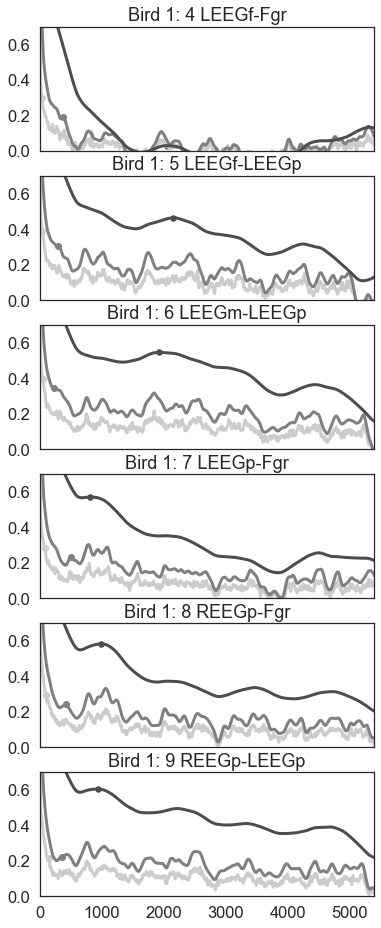

In [25]:
b = 0
autocorr_pds = period_from_autocorr('GammaDeltaRatio', b)
# save to dataframe
AllAutocorrPeriods = AllAutocorrPeriods.join(autocorr_pds)

Bird 2: 4 LEEGf-Fgr at 10s: 80s, at 1m: 4.8m, at 10m: 23.583333333333332m
Bird 2: 5 LEEGf-LEEGm at 10s: 119s, at 1m: 6.1m, at 10m: 28.15m
Bird 2: 6 LEEGm-LEEGp at 10s: 28s, at 1m: 6.233333333333333m, at 10m: 34.13333333333333m
Bird 2: 7 REEGf-Fgr at 10s: 53s, at 1m: 7.883333333333334m, at 10m: 23.633333333333333m
Bird 2: 8 REEGm-Fgr at 10s: 88s, at 1m: 5.416666666666667m, at 10m: 29.383333333333333m
Bird 2: 9 REEGf-REEGm at 10s: 67s, at 1m: 6.066666666666666m, at 10m: 27.333333333333332m


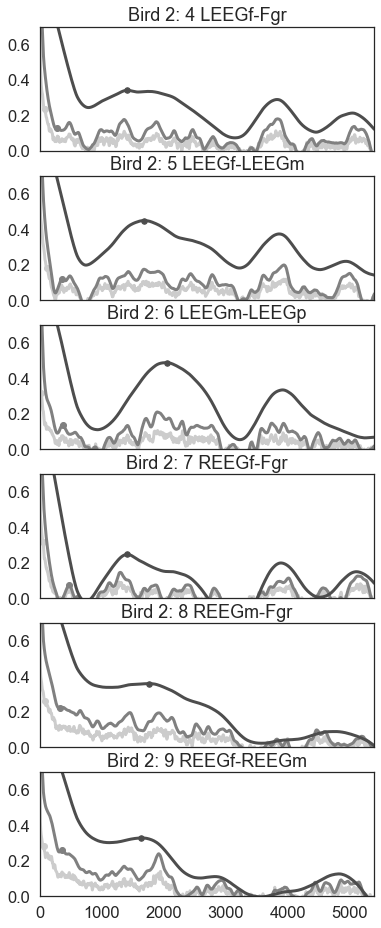

In [26]:
b = 1
autocorr_pds = period_from_autocorr('GammaDeltaRatio', b)
# save to dataframe
AllAutocorrPeriods = AllAutocorrPeriods.join(autocorr_pds)

Bird 3: 4LEEGf-LEEGp at 10s: 35s, at 1m: 10.866666666666667m, at 10m: 33.166666666666664m
Bird 3: 5LEEGf-LEEGm at 10s: 42s, at 1m: 14.766666666666667m, at 10m: 34.416666666666664m
Bird 3: 6LEEGm-LEEGp at 10s: 30s, at 1m: 10.633333333333333m, at 10m: 34.11666666666667m
Bird 3: 7REEGf-REEGp at 10s: 49s, at 1m: 14.066666666666666m, at 10m: 32.86666666666667m
Bird 3: 8REEGf-REEGm at 10s: 47s, at 1m: 15.283333333333333m, at 10m: 32.4m
Bird 3: 9REEGm-REEGp at 10s: 41s, at 1m: 8.533333333333333m, at 10m: 34.016666666666666m


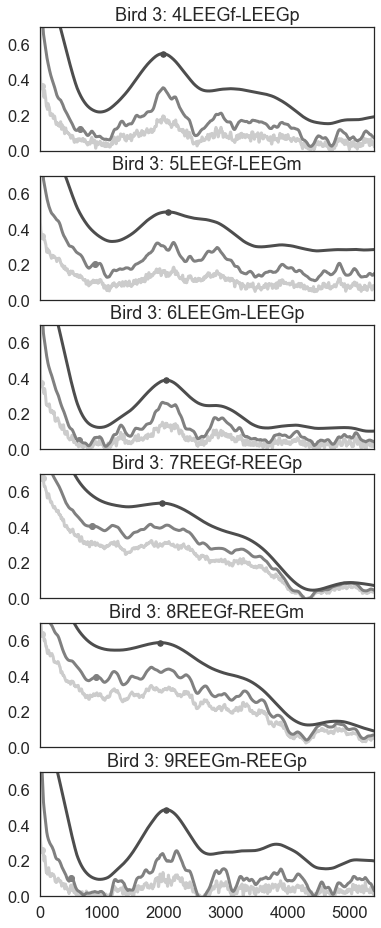

In [27]:
b = 2
autocorr_pds = period_from_autocorr('GammaDeltaRatio', b)
# save to dataframe
AllAutocorrPeriods = AllAutocorrPeriods.join(autocorr_pds)

Bird 4: 4LEEGf-LEEGp at 10s: 39s, at 1m: 5.95m, at 10m: 59.65m
Bird 4: 5LEEGm-LEEGp at 10s: 36s, at 1m: 5.933333333333334m, at 10m: nanm
Bird 4: 6LEEGm-LEEGf at 10s: 61s, at 1m: 7.75m, at 10m: 29.283333333333335m
Bird 4: 7REEGf-Fgr at 10s: 44s, at 1m: 5.216666666666667m, at 10m: 30.766666666666666m
Bird 4: 8REEGf-REEGm at 10s: 77s, at 1m: 2.4m, at 10m: 18.783333333333335m
Bird 4: 9REEGf-REEGp at 10s: 58s, at 1m: 13.466666666666667m, at 10m: 29.866666666666667m


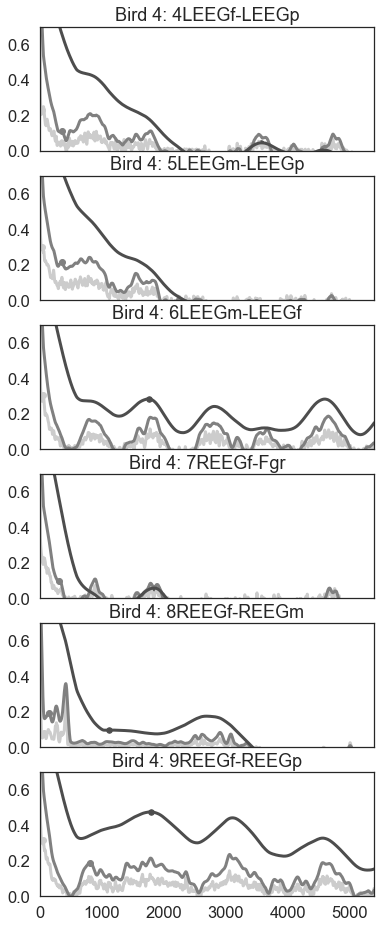

In [28]:
b = 3
autocorr_pds = period_from_autocorr('GammaDeltaRatio', b)
# save to dataframe
AllAutocorrPeriods = AllAutocorrPeriods.join(autocorr_pds)

Bird 5: 4LEEGf-LEEGp at 10s: 39s, at 1m: 6.766666666666667m, at 10m: 15.166666666666666m
Bird 5: 5LEEGf-LEEGm at 10s: 63s, at 1m: 7.466666666666667m, at 10m: 15.2m
Bird 5: 6LEEGm-LEEGp at 10s: 41s, at 1m: 6.633333333333334m, at 10m: 15.166666666666666m
Bird 5: 7REEGf-REEGp at 10s: 25s, at 1m: 10.7m, at 10m: 15.483333333333333m
Bird 5: 8REEGf-REEGm at 10s: 85s, at 1m: 7.933333333333334m, at 10m: 31.6m
Bird 5: 9REEGm-REEGp at 10s: 92s, at 1m: 6.933333333333334m, at 10m: 49.86666666666667m


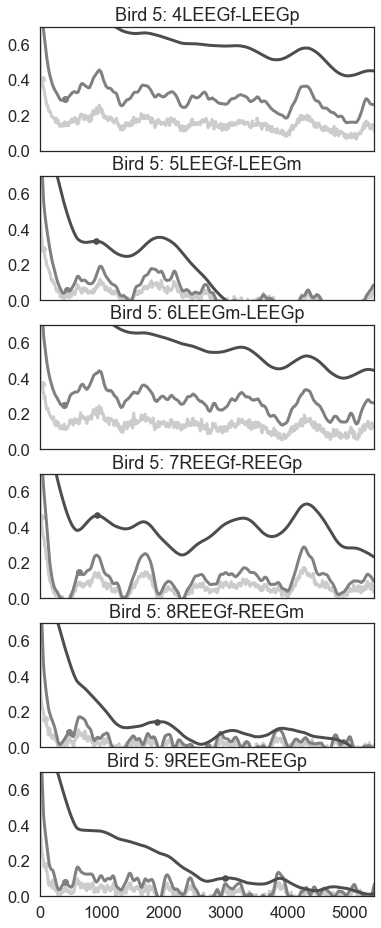

In [29]:
b = 4
autocorr_pds = period_from_autocorr('GammaDeltaRatio', b)
# save to dataframe
AllAutocorrPeriods = AllAutocorrPeriods.join(autocorr_pds)

In [30]:
AllAutocorrPeriods

Bird 1: 4 LEEGf-Fgr  Bird 1: 5 LEEGf-LEEGp  Bird 1: 6 LEEGm-LEEGp  \
10s_MA                     40                     46                     49   
1min_MA                   377                    302                    238   
10min_MA                 2053                   2157                   1930   

          Bird 1: 7 LEEGp-Fgr  Bird 1: 8 REEGp-Fgr  Bird 1: 9 REEGp-LEEGp  \
10s_MA                     87                   98                    152   
1min_MA                   500                  419                    357   
10min_MA                  808                  991                    946   

          Bird 2: 4 LEEGf-Fgr  Bird 2: 5 LEEGf-LEEGm  Bird 2: 6 LEEGm-LEEGp  \
10s_MA                     80                    119                     28   
1min_MA                   288                    366                    374   
10min_MA                 1415                   1689                   2048   

          Bird 2: 7 REEGf-Fgr  ...  Bird 4: 6LEEGm-LEEGf  Bird 4: 7REEGf-Fgr  \
10s_MA                     53  ...                    61                  44   
1min_MA                   473  ...                   465                 313   
10min_MA                 1418  ...                  1757                1846   

          Bird 4: 8REEGf-REEGm  Bird 4: 9REEGf-REEGp  Bird 5: 4LEEGf-LEEGp  \
10s_MA                      77                    58                    39   
1min_MA                    144                   808                   406   
10min_MA                  1127                  1792                   910   

          Bird 5: 5LEEGf-LEEGm  Bird 5: 6LEEGm-LEEGp  Bird 5: 7REEGf-REEGp  \
10s_MA                      63                    41                    25   
1min_MA                    448                   398                   642   
10min_MA                   912                   910                   929   

          Bird 5: 8REEGf-REEGm  Bird 5: 9REEGm-REEGp  
10s_MA                      85                    92  
1min_MA                    476                   416  
10min_MA                  1896                  2992  

[3 rows x 30 columns]

## Run on log(delta) and nPeaks of waveform

Bird 1: 4 LEEGf-Fgr at 10s: 110s, at 1m: 13.383333333333333m, at 10m: 17.366666666666667m
Bird 1: 5 LEEGf-LEEGp at 10s: 141s, at 1m: 13.133333333333333m, at 10m: 14.75m
Bird 1: 6 LEEGm-LEEGp at 10s: 48s, at 1m: 12.716666666666667m, at 10m: 15.983333333333333m
Bird 1: 7 LEEGp-Fgr at 10s: 209s, at 1m: 13.133333333333333m, at 10m: 16.35m
Bird 1: 8 REEGp-Fgr at 10s: 206s, at 1m: 13.383333333333333m, at 10m: 17.95m
Bird 1: 9 REEGp-LEEGp at 10s: 256s, at 1m: 7.15m, at 10m: 16.566666666666666m
Bird 2: 4 LEEGf-Fgr at 10s: 77s, at 1m: 5.116666666666666m, at 10m: 24.566666666666666m
Bird 2: 5 LEEGf-LEEGm at 10s: 114s, at 1m: 6.033333333333333m, at 10m: 31.166666666666668m
Bird 2: 6 LEEGm-LEEGp at 10s: 34s, at 1m: 5.866666666666666m, at 10m: 34.63333333333333m
Bird 2: 7 REEGf-Fgr at 10s: 55s, at 1m: 6.016666666666667m, at 10m: 23.35m
Bird 2: 8 REEGm-Fgr at 10s: 28s, at 1m: 6.683333333333334m, at 10m: 43.71666666666667m
Bird 2: 9 REEGf-REEGm at 10s: 19s, at 1m: 4.883333333333334m, at 10m: 44.93333

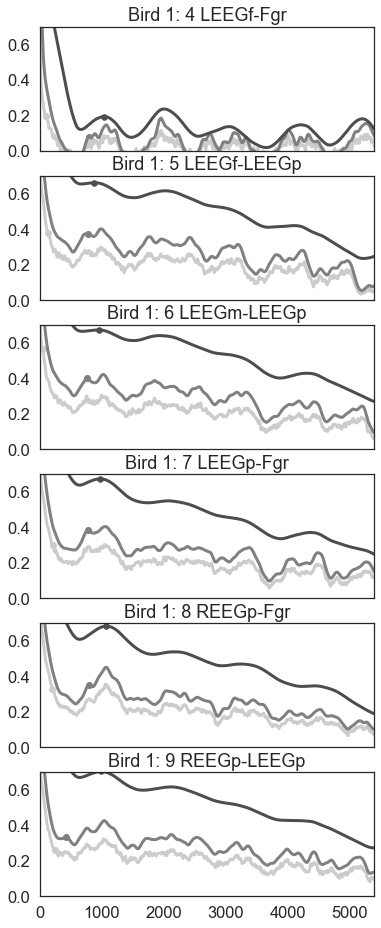

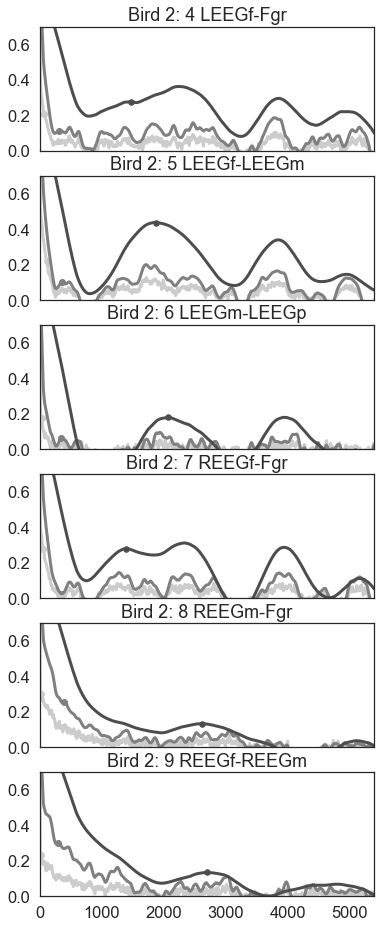

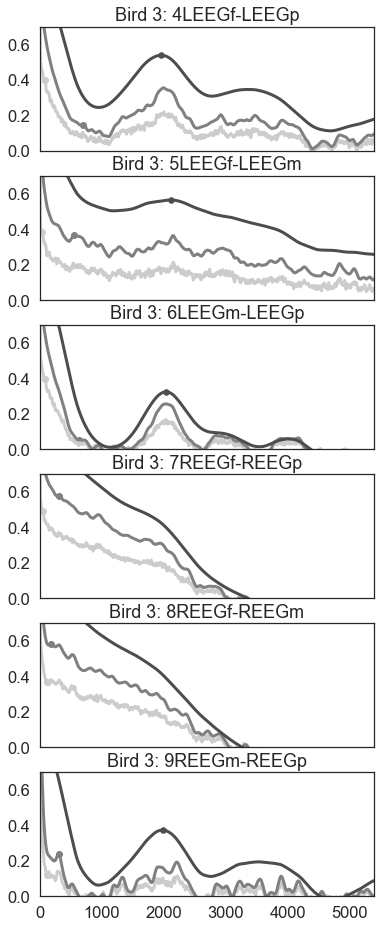

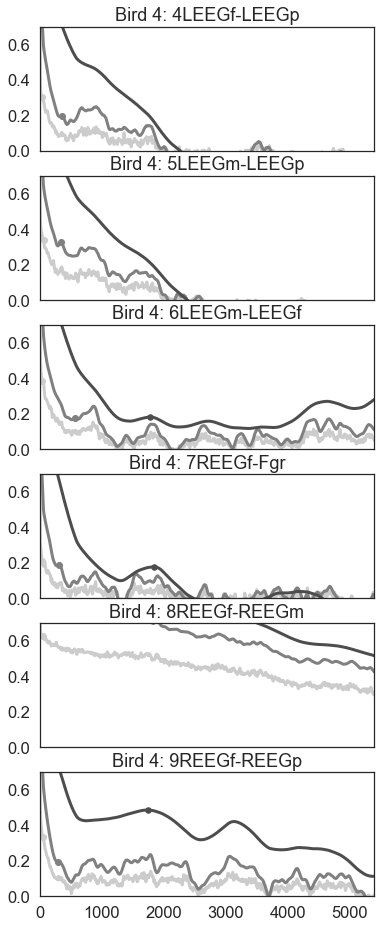

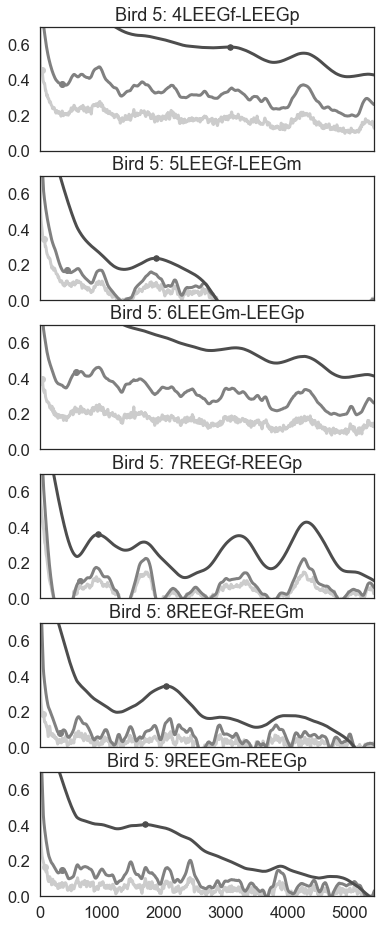

In [31]:
variable = 'DeltaLog'

# init dataframe for all birds
AllAutocorrPeriods_Deltalog = pd.DataFrame([], index=['10s_MA', '1min_MA', '10min_MA'])

for b in range(nBirds):
    autocorr_pds = period_from_autocorr(variable, b)
    AllAutocorrPeriods_Deltalog =  AllAutocorrPeriods_Deltalog.join(autocorr_pds)

Bird 1: 4 LEEGf-Fgr at 10s: 77s, at 1m: 5.933333333333334m, at 10m: 24.866666666666667m
Bird 1: 5 LEEGf-LEEGp at 10s: 96s, at 1m: 6.916666666666667m, at 10m: 15.0m
Bird 1: 6 LEEGm-LEEGp at 10s: 125s, at 1m: 6.083333333333333m, at 10m: 15.433333333333334m
Bird 1: 7 LEEGp-Fgr at 10s: 49s, at 1m: 7.433333333333334m, at 10m: 16.966666666666665m
Bird 1: 8 REEGp-Fgr at 10s: 153s, at 1m: 7.033333333333333m, at 10m: 17.45m
Bird 1: 9 REEGp-LEEGp at 10s: 49s, at 1m: 7.083333333333333m, at 10m: 17.216666666666665m
Bird 2: 4 LEEGf-Fgr at 10s: 337s, at 1m: 8.566666666666666m, at 10m: 30.7m
Bird 2: 5 LEEGf-LEEGm at 10s: 238s, at 1m: 8.833333333333334m, at 10m: 30.133333333333333m
Bird 2: 6 LEEGm-LEEGp at 10s: 129s, at 1m: 15.783333333333333m, at 10m: 29.483333333333334m
Bird 2: 7 REEGf-Fgr at 10s: 387s, at 1m: 8.433333333333334m, at 10m: 29.7m
Bird 2: 8 REEGm-Fgr at 10s: 314s, at 1m: 8.566666666666666m, at 10m: 29.983333333333334m
Bird 2: 9 REEGf-REEGm at 10s: 116s, at 1m: 7.116666666666666m, at 10m

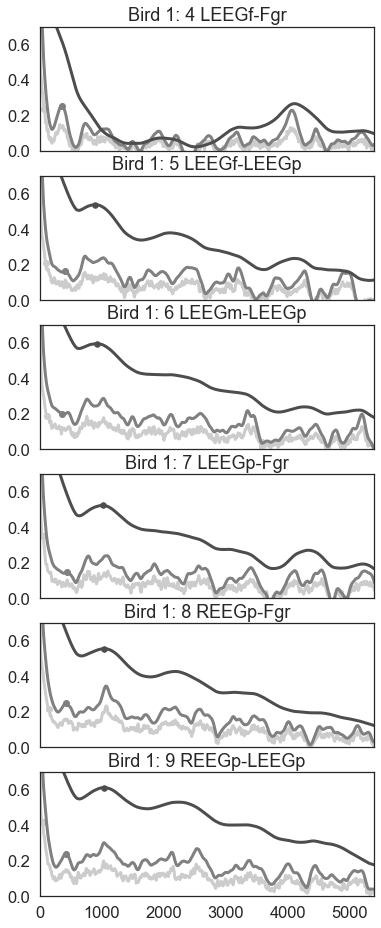

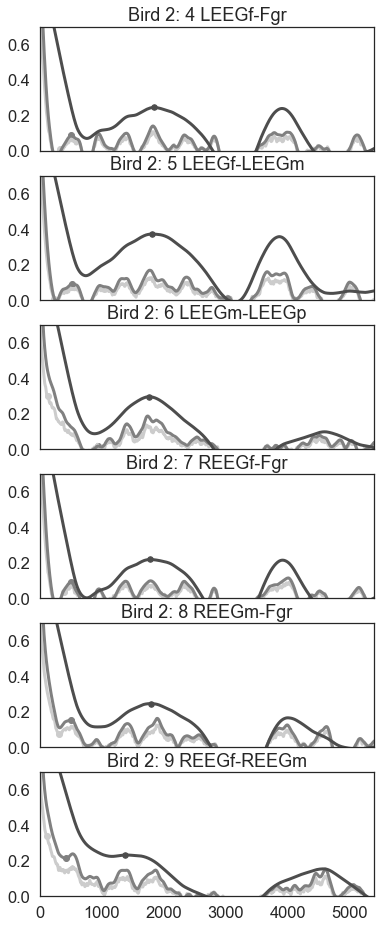

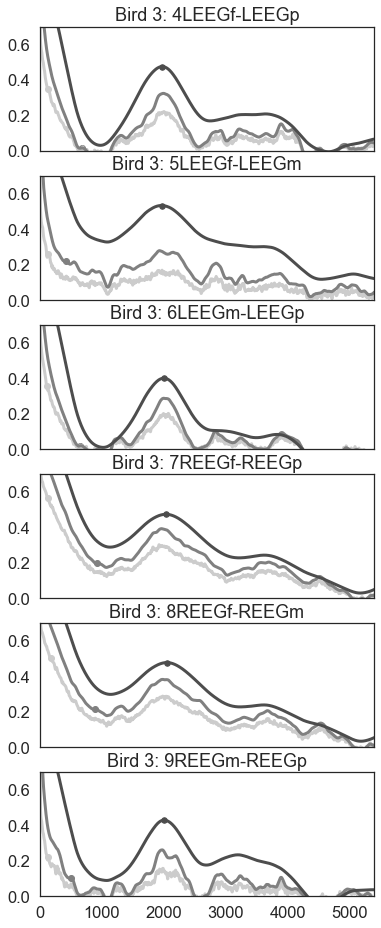

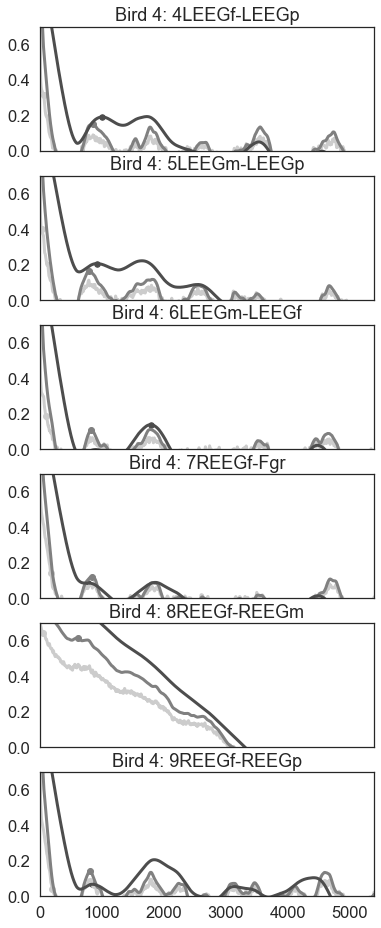

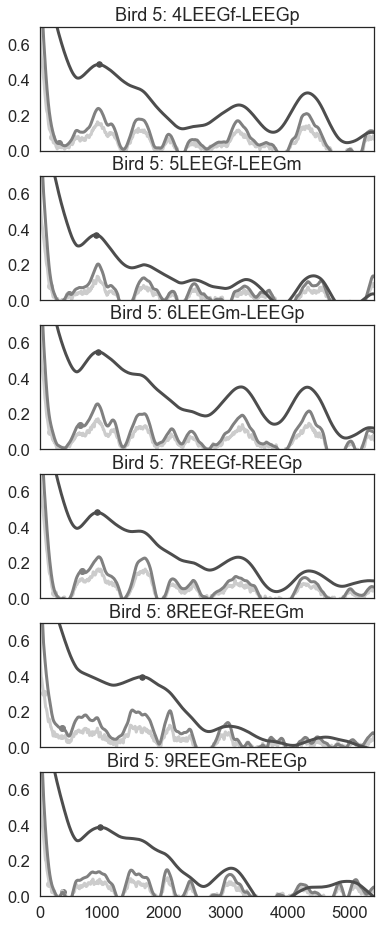

In [32]:
variable = 'nPeaks'

# init dataframe for all birds
AllAutocorrPeriods_nPeaks = pd.DataFrame([], index=['10s_MA', '1min_MA', '10min_MA'])

for b in range(nBirds):
    autocorr_pds = period_from_autocorr(variable, b)
    AllAutocorrPeriods_nPeaks =  AllAutocorrPeriods_nPeaks.join(autocorr_pds)

# Ultradian rhythms vs sleep stages

## fit sine wave to data, get phase, compare to sleep stages

### ultradian_phase_vs_stage

In [33]:
def ultradian_phase_vs_stage(ch, variable, moving_avg, moving_avg_s, AllAutocorrPeriods=AllAutocorrPeriods,
                             printResults=False, makePlots=False):
    '''
    ch: which channel to test
    variable: GammaDeltaRatio, DeltaLog, nPeaks, etc
    moving_avg: which period (determined by autocorr of a moving avg) to use as initial guess
    moving_avg_s: defines the data to fit the sinewave to -- use 1 to effectively use the raw data
    '''
    
    b_num = int(ch[5]) - 1

    # get the corresponding pd found for that channel
    pd_minutes = AllAutocorrPeriods[ch][moving_avg]/60
    pd_minutes

    # get a copy of relevant variables w/ sleep scores and epoch #
    data_scores = SleepVariables[ch][[variable,
                                      'sleep scores', 'Epoch']].loc[lightsOffSec[b_num]:lightsOnSec[b_num]].copy()
    # z-score
    data_scores = data_scores.dropna()
    time_axis = data_scores.index
    rawdata = data_scores[variable]
    z_data = pd.Series(stat.zscore(rawdata.dropna()), index=time_axis)

    # get moving average
    data = z_data.rolling(moving_avg_s, min_periods=1).mean()



    # define sinusoid to fit to the data
    def sine_func(x, freq, phase):
        amplitude = 0.25  # set these as constants to minimize the number of things we need to fit
        offset = 0        # z-scored: should be zero mean
        return np.sin(2* np.pi * x * freq + phase) * amplitude + offset 

    # define starting estimate
    guess_freq = 1/(pd_minutes*60) # based on period determined from autocorr
    guess_phase = np.pi
    p0=[guess_freq, 
        guess_phase]

    t = time_axis

    # first estimate
    data_first_guess = sine_func(t, *p0)

    # run fit
    fit = scipy.optimize.curve_fit(sine_func, t, data, p0=p0, maxfev=10000,
                                   method='dogbox')

    # recreate the fitted curve using the optimized parameters
    data_fit = sine_func(t, *fit[0])

    if makePlots:
        plt.figure(figsize=figsize)
        plt.plot(time_axis, data, '.', color=color3, alpha=alpha_darker)
        plt.plot(time_axis, data_first_guess, label='first guess')
        plt.plot(time_axis, data_fit, label='after fitting', linewidth=linewidth/2, color='r')
        plt.legend()
        plt.ylim(-1, 1)

    fit_freq = fit[0][0]
    fit_pd   = 1/(fit_freq*60)
    fit_phase = fit[0][1]
    wrapped_phase = (fit_phase + np.pi) % (2 * np.pi) - np.pi # convert to a number between -pi and pi

    if printResults:
        print('Period from autocorr:', 1/(guess_freq*60), 'minutes')
        print('Period from fitted sinewave:', np.round(1/(fit_freq*60), decimals=2), 'minutes')
        print('Phase from fitted sinewave:', np.round(wrapped_phase, decimals=2), 'rads')

    ## use fit sine wave to determine phase at each point

    # get array of instantaneous phases
    phase_array = 2*np.pi*fit_freq*time_axis + wrapped_phase

    wrapped_phase_array = (phase_array + np.pi) % (2 * np.pi) - np.pi

    if makePlots:
        plt.figure(figsize=figsize)
        plt.plot(time_axis, data_fit, label='fitted sinewave', linewidth=linewidth/2, color='r')
        plt.plot(time_axis, wrapped_phase_array, label='instantaneous phase')
        plt.legend()
        plt.title(ch)


    if makePlots:
        plt.figure(figsize=figsize)

        plt.subplot(1,3,1)
        plt.plot(wrapped_phase_array,  z_data, '.', label='data', alpha=.1, color=color3)
        plt.plot(wrapped_phase_array, data_fit,'.', label='fitted sine', color='r')
        plt.legend()
        plt.ylim(-1,1)
        plt.xlabel('Phase')

    # get most common score at each phase

    data_scores['Phase'] = wrapped_phase_array

    # Round phase to nearest 100th

    data_scores_epochs = data_scores.groupby('Epoch').mean()
    data_scores_epochs['Phase rounded'] = np.round(data_scores_epochs['Phase'], decimals=2)

    # Flip IS and SWS number scores so that taking the mean makes sense (ie, so IS is between SWS and REM)
    flipped_scores = data_scores_epochs['sleep scores'].copy()
    flipped_scores[data_scores_epochs['sleep scores']==3] = 4
    flipped_scores[data_scores_epochs['sleep scores']==4] = 3

    data_scores_epochs['sleep scores flipped'] = flipped_scores

    ## Plot avg score at each phase

    flipped_scores_mean = data_scores_epochs.groupby('Phase rounded')['sleep scores flipped'].mean()

    if makePlots:

        plt.subplot(1,3,2)
        plt.plot(flipped_scores_mean)
        plt.plot()

        plt.yticks([3.5,4,4.5], ['more SWS', 'IS', 'more REM']);
        plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
                   ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
        plt.ylabel('Average stage')
        plt.xlabel('Phase of ' + variable)
        plt.title(ch)

    ## Plot avg phase of each score

    mean_phase_by_score = data_scores_epochs.groupby('sleep scores')['Phase'].mean()
    std_phase_by_score = data_scores_epochs.groupby('sleep scores')['Phase'].std()
    n_by_score = data_scores_epochs.groupby('sleep scores')['Phase'].count()
    sem_phase_by_score = std_phase_by_score/np.sqrt(n_by_score)

    if makePlots:
        plt.subplot(1,3,3)
        plt.errorbar(mean_phase_by_score.index, mean_phase_by_score.values, yerr=sem_phase_by_score.values,
                     color=color3, alpha=linealpha)
        for stage in [3,4,5]:
            plt.plot(stage, mean_phase_by_score[stage], 'o', color=colors[stage])

        plt.xlabel('Stage')
        plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
        plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
        plt.axhline(0, color='k', alpha=alpha_main)

        plt.tight_layout()
        
    return(data_scores_epochs, fit_pd)

## Test on 1 bird

### test on 1 bird: long rhythm

Period from autocorr: 34.01666666666667 minutes
Period from fitted sinewave: 32.97 minutes
Phase from fitted sinewave: -1.67 rads


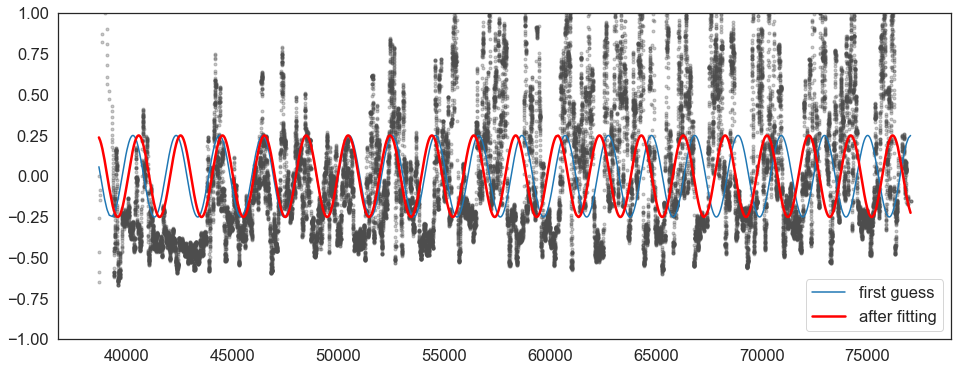

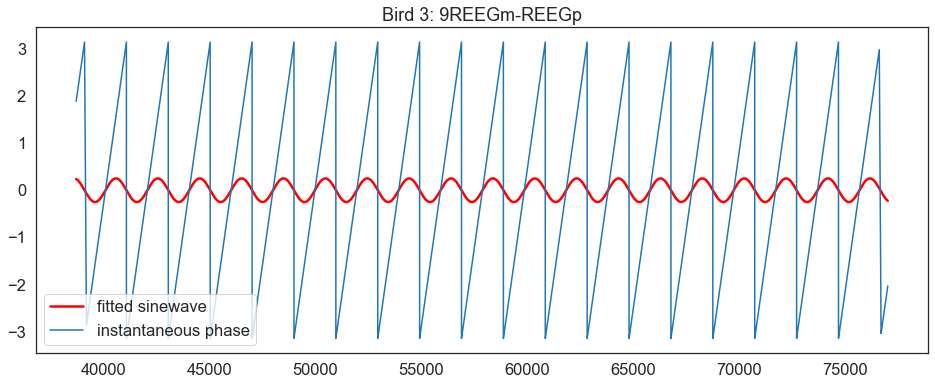

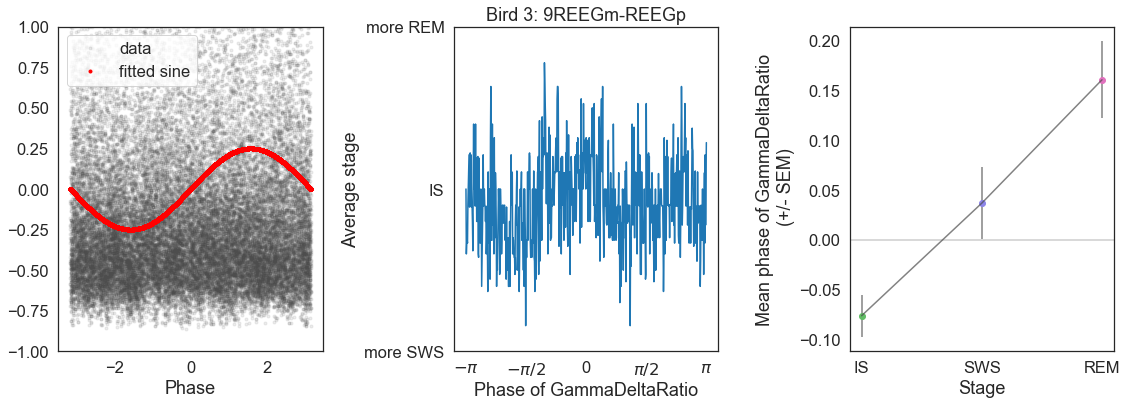

In [34]:
ch = 'Bird 3: 9REEGm-REEGp' # bird from Fig 06a (example dot plot)
variable = 'GammaDeltaRatio'
moving_avg = '10min_MA'
moving_avg_s = 60

phases_by_epoch, fit_pd = ultradian_phase_vs_stage(ch, variable, moving_avg, moving_avg_s,
                                           printResults=True, makePlots=True)

## Run on all birds: 10 min MA

In [35]:
variable = 'GammaDeltaRatio'
moving_avg = '10min_MA'
moving_avg_s = 1 # defines the data to fit the sinewave to -- use 1 to effectively use the raw data

# init
MeanScore_flipped_byPhase = {}
MeanPhase_byScore = {}
FreqIS_byPhase  = {}
FreqSWS_byPhase = {}
FreqREM_byPhase = {}


for bird in birds:
    print(bird)
    b_num = int(bird[5]) - 1
    
    # get channels for each bird
    all_channels = list(SleepVariables.keys())
    EEGchannels = np.sort([x for x in all_channels if bird + ': ' in x])

    # init
    bird_scores_by_phase = pd.DataFrame([])
    bird_ISfreq_by_phase = pd.DataFrame([])
    bird_SWSfreq_by_phase = pd.DataFrame([])
    bird_REMfreq_by_phase = pd.DataFrame([])
    bird_phases_by_score = pd.DataFrame([])
    
    # Calc phases for each channel
    for ch in EEGchannels:
        if not np.isnan(AllAutocorrPeriods[ch][moving_avg]):
            phases_by_epoch, fit_pd = ultradian_phase_vs_stage(ch, variable, moving_avg, moving_avg_s)

            flipped_scores_mean = phases_by_epoch.groupby('Phase rounded')['sleep scores flipped'].mean()
            mean_phase_by_score = phases_by_epoch.groupby('sleep scores')['Phase'].mean()
            score_epochs_by_phase = phases_by_epoch.groupby('Phase rounded')['sleep scores'].value_counts()
            
            bird_scores_by_phase[ch] = (flipped_scores_mean)
            bird_phases_by_score[ch] = (mean_phase_by_score)
            
            # for each 1/100th of a phase, get the % of each of the sleep scores
            tmp_total_eps = score_epochs_by_phase.groupby('Phase rounded').sum()
            for stage, df in zip([3,4,5], [bird_ISfreq_by_phase, bird_SWSfreq_by_phase, bird_REMfreq_by_phase]):
                # number of epochs of each stage at a given phase
                tmp_nStage_eps = score_epochs_by_phase[:, stage]
                # get proportion
                freq_nStage_epochs = tmp_nStage_eps/tmp_total_eps
                # save to dataframe
                df[ch] = (freq_nStage_epochs)
        
    # Save to dict
    MeanScore_flipped_byPhase[bird] = bird_scores_by_phase
    MeanPhase_byScore[bird]         = bird_phases_by_score
    FreqIS_byPhase[bird]  = 100*bird_ISfreq_by_phase.fillna(0)
    FreqSWS_byPhase[bird] = 100*bird_SWSfreq_by_phase.fillna(0)
    FreqREM_byPhase[bird] = 100*bird_REMfreq_by_phase.fillna(0)
    

Bird 1
Bird 2
Bird 3
Bird 4
Bird 5


### Plot mean phase by score

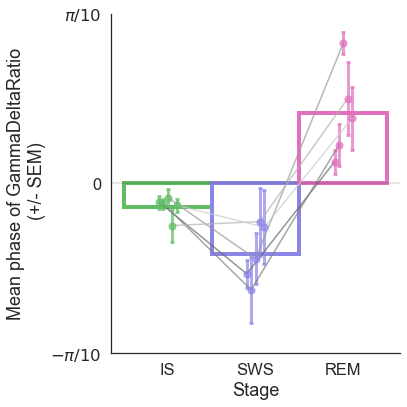

In [36]:
Means = pd.DataFrame([])
plt.figure(figsize=(6,6))

for bird in birds:
    b_num = int(bird[5]) - 1
    jitter = -.1 + b_num*.05
    
    # include all channels
    #channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    channels = MeanPhase_byScore[bird].columns
    
    # calculate means across channels
    mean_phase_by_score = MeanPhase_byScore[bird][channels].mean(axis=1)
    std_phase_by_score  = MeanPhase_byScore[bird][channels].std(axis=1)
    n_by_score          = MeanPhase_byScore[bird][channels].count(axis=1)
    sem_phase_by_score  = std_phase_by_score/np.sqrt(n_by_score)
    
    # lines, color-coded by bird
    plt.plot(mean_phase_by_score.index + jitter,
             mean_phase_by_score.values, 
             color=colors_birds[b_num], alpha=linealpha)
    
    # dots + errorbars, color-coded by stage
    for stage in [3,4,5]:
        plt.errorbar(stage + jitter, mean_phase_by_score[stage], yerr=sem_phase_by_score[stage],
                 marker='o',markersize=7, color=colors[stage], 
                        alpha=0.7, capsize=2, capthick=3, elinewidth=3)

    plt.xlabel('Stage')
    plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
    plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
    plt.axhline(0, color='k', alpha=.025)
    
    # Save mean to dataframe
    Means[bird] = mean_phase_by_score
    

# Bar graph of means
for stage in [3,4,5]:
    plt.bar(stage, Means.mean(axis=1)[stage], width=1, color='none', edgecolor=colors[stage], linewidth=bar_linewidth)

plt.yticks([-np.pi/10, 0, np.pi/10], ['$-\pi/10$', '0', '$\pi/10$']);

sns.despine()
plt.tight_layout()

#if savePlots:
#    name = saveAsPath + saveAsName + 'f_mean_phase_by_score_' + variable + '_' + moving_avg + '_SEMs'
#    plt.savefig(name + '.pdf')

#### FIGURE 6F

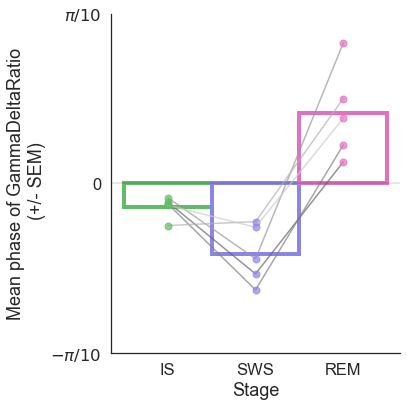

In [37]:
Means = pd.DataFrame([])
plt.figure(figsize=(6,6))

for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include all channels
    #channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    channels = MeanPhase_byScore[bird].columns
    
    # calculate means across channels
    mean_phase_by_score = MeanPhase_byScore[bird][channels].mean(axis=1)
    std_phase_by_score  = MeanPhase_byScore[bird][channels].std(axis=1)
    n_by_score          = MeanPhase_byScore[bird][channels].count(axis=1)
    sem_phase_by_score  = std_phase_by_score/np.sqrt(n_by_score)
    
    # lines, color-coded by bird
    plt.plot(mean_phase_by_score.index,
             mean_phase_by_score.values, 
             color=colors_birds[b_num], alpha=linealpha)
    
    # dots + errorbars, color-coded by stage
    for stage in [3,4,5]:
        plt.plot(stage, mean_phase_by_score[stage], 
                 marker='o',markersize=7, color=colors[stage], 
                 alpha=0.7)

    plt.xlabel('Stage')
    plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
    plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
    plt.axhline(0, color='k', alpha=.025)
    
    # Save mean to dataframe
    Means[bird] = mean_phase_by_score
    

# Bar graph of means
for stage in [3,4,5]:
    plt.bar(stage, Means.mean(axis=1)[stage], width=1, color='none', edgecolor=colors[stage], linewidth=bar_linewidth)

plt.yticks([-np.pi/10, 0, np.pi/10], ['$-\pi/10$', '0', '$\pi/10$']);

sns.despine()
plt.tight_layout()

if savePlots:
    name = saveAsPath + saveAsName + 'f_mean_phase_by_score_' + variable + '_' + moving_avg
    plt.savefig(name + '.pdf')

#### save to csv

In [38]:
if saveData:
    for bird in birds:
        tmp = MeanPhase_byScore[bird]
        tmp.to_csv(saveAsPath + saveAsName + 'f_mean_phase_by_score_' + variable + '_' + moving_avg + '_' + bird + '.csv')

#### FIGURE 6F STATS

In [39]:
Means

Bird 1    Bird 2    Bird 3    Bird 4    Bird 5
sleep scores                                                  
3.0          -0.034359 -0.037644 -0.026202 -0.077740 -0.040301
4.0          -0.167235 -0.196801 -0.139327 -0.070566 -0.080817
5.0           0.039932  0.071254  0.259818  0.157176  0.120706

In [40]:
stat.f_oneway(Means.loc[3], Means.loc[4], Means.loc[5])

F_onewayResult(statistic=24.71934125622462, pvalue=5.551829388164359e-05)

In [41]:
stat.ttest_rel(Means.loc[4], Means.loc[5])

Ttest_relResult(statistic=-7.139151880284014, pvalue=0.0020360602959128135)

In [42]:
stat.ttest_rel(Means.loc[3], Means.loc[5])

Ttest_relResult(statistic=-4.4232658958692515, pvalue=0.011481773434769279)

In [43]:
stat.ttest_rel(Means.loc[3], Means.loc[4])

Ttest_relResult(statistic=2.8438110540786146, pvalue=0.04668716116336096)

### Plot mean score by phase

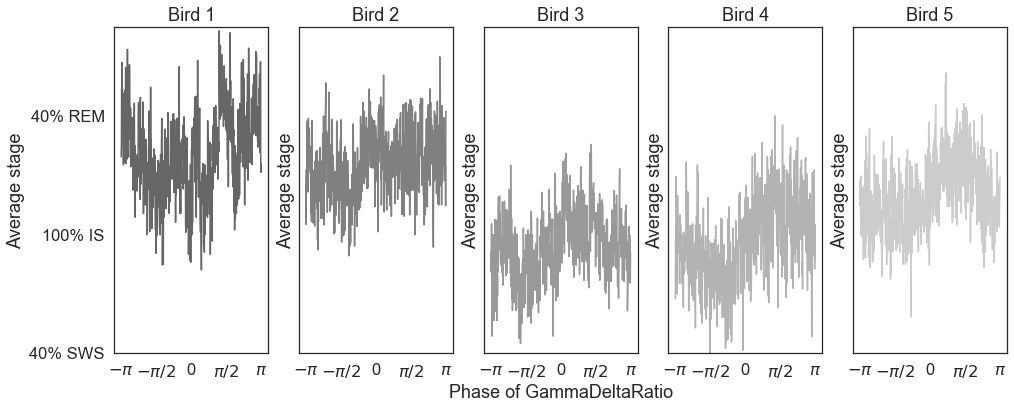

In [44]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG_best[b_num]]
    
    flipped_scores_mean = MeanScore_flipped_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(flipped_scores_mean, color=colors_birds[b_num])

    if b_num == 0:
        plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
    else:
        plt.yticks([])
    
    plt.ylim(3.6,4.7)
    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('Average stage')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = flipped_scores_mean

#if savePlots:
#    name = saveAsPath + saveAsName + 'e_mean_score_by_phase_' + variable + '_' + moving_avg + '_individuals'
#    plt.savefig(name + '.pdf')

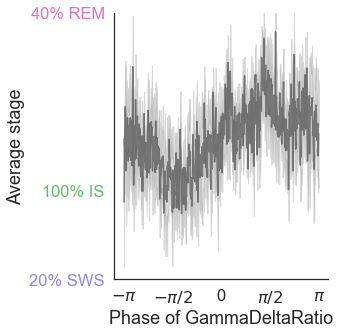

In [45]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(5,5))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=color3, alpha=alpha_main)
plt.plot(grandmean, color=color3, alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('Average stage')
plt.yticks([3.8, 4, 4.4], ['20% SWS', '100% IS', '40% REM']);
plt.ylim(3.8, 4.4)

flipped_colors = (colors[4], colors[3], colors[5])
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(flipped_colors, ax.yaxis.get_ticklabels())]

sns.despine()
plt.tight_layout()

if savePlots:
    name = saveAsPath + saveAsName + 'e_mean_score_by_phase_' + variable + '_' + moving_avg + '_ALL'
    plt.savefig(name + '.pdf')

#### save to csv

In [46]:
if saveData:
    for bird in birds:
        tmp = MeanScore_flipped_byPhase[bird]
        tmp.to_csv(saveAsPath + saveAsName + 'e_mean_score_by_phase_' + variable + '_' + moving_avg + '_' + bird + '.csv')

## FIGURE 6E

### Plot freq of SWS by phase

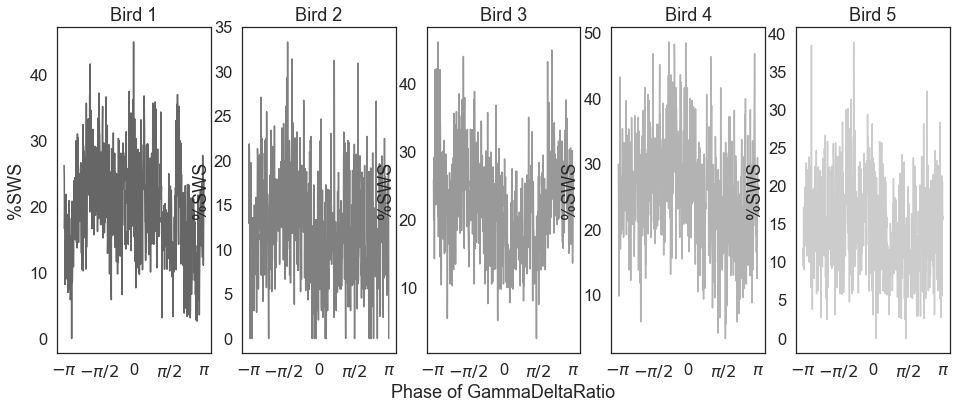

In [60]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG_best[b_num]]
    
    freq_stage_mean = FreqSWS_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(freq_stage_mean, color=colors_birds[b_num])


    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('%SWS')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = freq_stage_mean


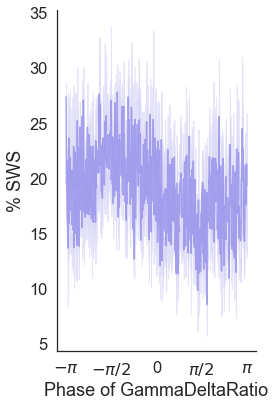

In [61]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(4,6))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=colors[4], alpha=alpha_main)
plt.plot(grandmean, color=colors[4], alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('% SWS')

sns.despine()
plt.tight_layout()

if savePlots:
    name = saveAsPath + saveAsName + 'e_percSWS_by_phase_' + variable + '_' + moving_avg + '_ALL'
    plt.savefig(name + '.pdf')

#### save to csv

In [62]:
if saveData:
    tmp = Means
    tmp.to_csv(saveAsPath + saveAsName + 'e_percSWS_by_phase_' + variable + '_' + moving_avg + '_' + bird + '.csv')

### Plot freq of IS by phase

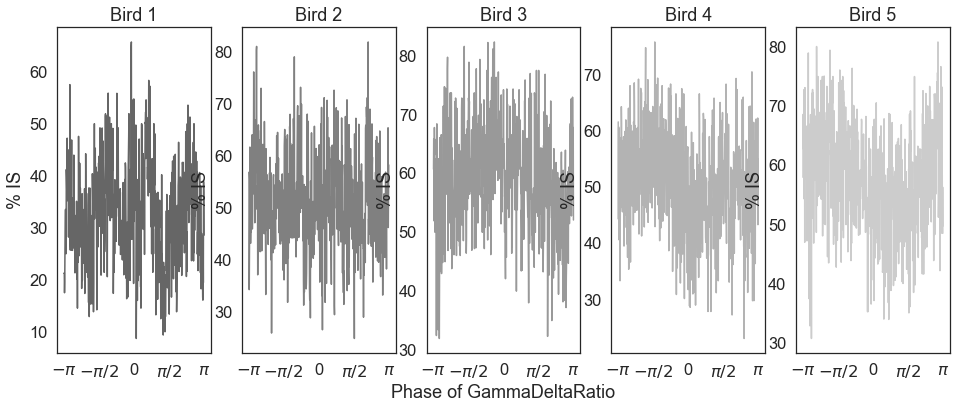

In [63]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG_best[b_num]]
    
    freq_stage_mean = FreqIS_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(freq_stage_mean, color=colors_birds[b_num])


    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('% IS')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = freq_stage_mean


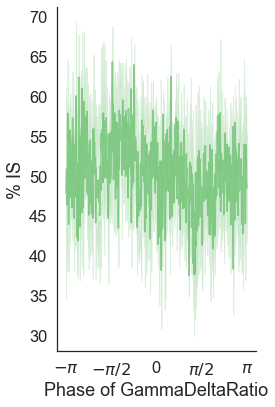

In [64]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(4,6))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=colors[3], alpha=alpha_main)
plt.plot(grandmean, color=colors[3], alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('% IS')

sns.despine()
plt.tight_layout()

if savePlots:
    name = saveAsPath + saveAsName + 'e_percIS_by_phase_' + variable + '_' + moving_avg + '_ALL'
    plt.savefig(name + '.pdf')

#### save to csv

In [65]:
if saveData:
    tmp = Means
    tmp.to_csv(saveAsPath + saveAsName + 'e_percIS_by_phase_' + variable + '_' + moving_avg + '_' + bird + '.csv')

### Plot freq of REM by phase

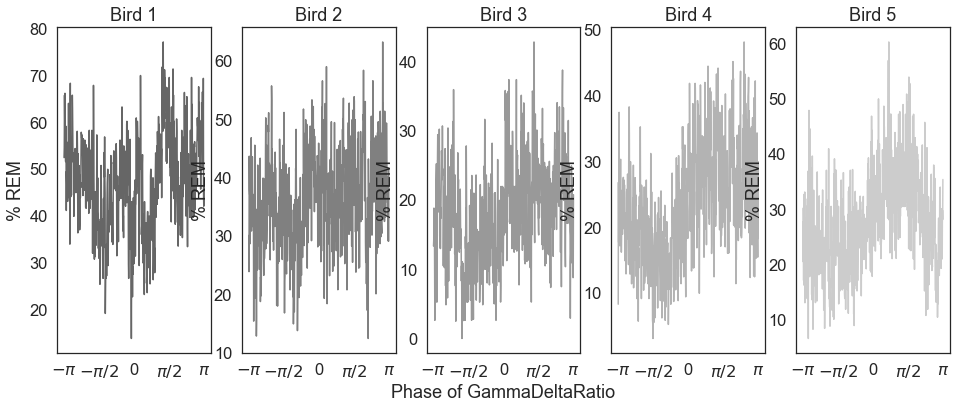

In [66]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG_best[b_num]]
    
    freq_stage_mean = FreqREM_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(freq_stage_mean, color=colors_birds[b_num])


    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('% REM')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = freq_stage_mean


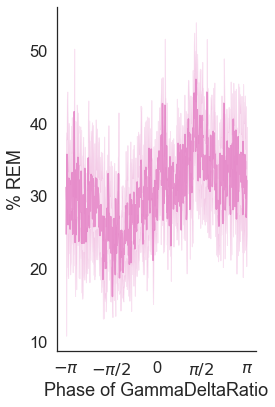

In [67]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(4,6))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=colors[5], alpha=alpha_main)
plt.plot(grandmean, color=colors[5], alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('% REM')

sns.despine()
plt.tight_layout()

if savePlots:
    name = saveAsPath + saveAsName + 'e_percREM_by_phase_' + variable + '_' + moving_avg + '_ALL'
    plt.savefig(name + '.pdf')

#### save to csv

In [68]:
if saveData:
    tmp = Means
    tmp.to_csv(saveAsPath + saveAsName + 'e_percREM_by_phase_' + variable + '_' + moving_avg + '_' + bird + '.csv')

## Run on all birds: 10 s MA

In [97]:
variable = 'GammaDeltaRatio'
moving_avg = '10s_MA'
moving_avg_s = 1 # defines the data to fit the sinewave to -- use 1 to effectively use the raw data

# init
MeanScore_flipped_byPhase = {}
MeanPhase_byScore = {}
for bird in birds:
    print(bird)
    b_num = int(bird[5]) - 1
    
    # get channels for each bird
    all_channels = list(SleepVariables.keys())
    EEGchannels = np.sort([x for x in all_channels if bird + ': ' in x])

    # init
    bird_scores_by_phase = pd.DataFrame([])
    bird_phases_by_score = pd.DataFrame([])
    
    # Calc phases for each channel
    for ch in EEGchannels:
        if not np.isnan(AllAutocorrPeriods[ch][moving_avg]):
            phases_by_epoch, fit_pd = ultradian_phase_vs_stage(ch, variable, moving_avg, moving_avg_s)

            flipped_scores_mean = phases_by_epoch.groupby('Phase rounded')['sleep scores flipped'].mean()
            mean_phase_by_score = phases_by_epoch.groupby('sleep scores')['Phase'].mean()

            bird_scores_by_phase[ch] = (flipped_scores_mean)
            bird_phases_by_score[ch] = (mean_phase_by_score)
        
    # Save to dict
    MeanScore_flipped_byPhase[bird] = bird_scores_by_phase
    MeanPhase_byScore[bird]         = bird_phases_by_score


Bird 1
Bird 2
Bird 3
Bird 4
Bird 5


### Plot mean phase by score

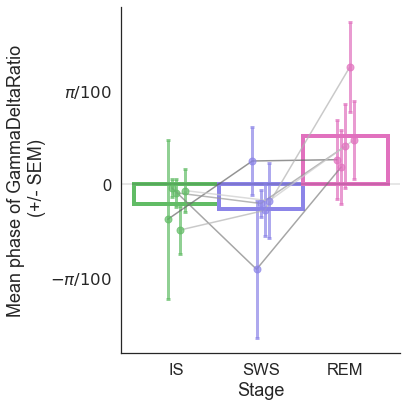

In [98]:
Means = pd.DataFrame([])
plt.figure(figsize=(6,6))

for bird in birds:
    b_num = int(bird[5]) - 1
    jitter = -.1 + b_num*.05
    
    # include all channels
    channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    
    # calculate means across channels
    mean_phase_by_score = MeanPhase_byScore[bird][channels].mean(axis=1)
    std_phase_by_score  = MeanPhase_byScore[bird][channels].std(axis=1)
    n_by_score          = MeanPhase_byScore[bird][channels].count(axis=1)
    sem_phase_by_score  = std_phase_by_score/np.sqrt(n_by_score)
    
    # lines, color-coded by bird
    plt.plot(mean_phase_by_score.index + jitter,
             mean_phase_by_score.values, 
             color=colors_birds[b_num], alpha=linealpha)
    
    # dots + errorbars, color-coded by stage
    for stage in [3,4,5]:
        plt.errorbar(stage + jitter, mean_phase_by_score[stage], yerr=sem_phase_by_score[stage],
                 marker='o',markersize=7, color=colors[stage], 
                        alpha=0.7, capsize=2, capthick=3, elinewidth=3)

    plt.xlabel('Stage')
    plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
    plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
    plt.axhline(0, color='k', alpha=.025)
    
    # Save mean to dataframe
    Means[bird] = mean_phase_by_score
    

# Bar graph of means
for stage in [3,4,5]:
    plt.bar(stage, Means.mean(axis=1)[stage], width=1, color='none', edgecolor=colors[stage], linewidth=bar_linewidth)

plt.yticks([-np.pi/100, 0, np.pi/100], ['$-\pi/100$', '0', '$\pi/100$']);

sns.despine()
plt.tight_layout()

#if savePlots:
#    name = saveAsPath + saveAsName + 'g_mean_phase_by_score_' + variable + '_' + moving_avg + '_SEMs'
#    plt.savefig(name + '.pdf')

#### FIGURE 6G

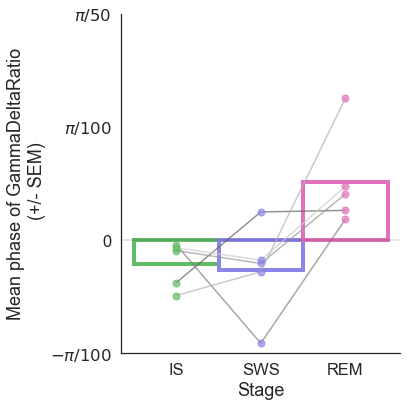

In [99]:
Means = pd.DataFrame([])
plt.figure(figsize=(6,6))

for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include all channels
    channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    
    # calculate means across channels
    mean_phase_by_score = MeanPhase_byScore[bird][channels].mean(axis=1)
    std_phase_by_score  = MeanPhase_byScore[bird][channels].std(axis=1)
    n_by_score          = MeanPhase_byScore[bird][channels].count(axis=1)
    sem_phase_by_score  = std_phase_by_score/np.sqrt(n_by_score)
    
    # lines, color-coded by bird
    plt.plot(mean_phase_by_score.index,
             mean_phase_by_score.values, 
             color=colors_birds[b_num], alpha=linealpha)
    
    # dots + errorbars, color-coded by stage
    for stage in [3,4,5]:
        plt.plot(stage, mean_phase_by_score[stage], 
                 marker='o',markersize=7, color=colors[stage], 
                 alpha=0.7)

    plt.xlabel('Stage')
    plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
    plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
    plt.axhline(0, color='k', alpha=.025)
    
    # Save mean to dataframe
    Means[bird] = mean_phase_by_score
    

# Bar graph of means
for stage in [3,4,5]:
    plt.bar(stage, Means.mean(axis=1)[stage], width=1, color='none', edgecolor=colors[stage], linewidth=bar_linewidth)

plt.yticks([-np.pi/100, 0, np.pi/100, np.pi/50], ['$-\pi/100$', '0', '$\pi/100$','$\pi/50$']);
plt.ylim(-np.pi/100, np.pi/50)

sns.despine()
plt.tight_layout()

if savePlots:
    name = saveAsPath + saveAsName + 'g_mean_phase_by_score_' + variable + '_' + moving_avg
    plt.savefig(name + '.pdf')

#### save to csv

In [100]:
if saveData:
    for bird in birds:
        tmp = MeanPhase_byScore[bird]
        tmp.to_csv(saveAsPath + saveAsName + 'f_mean_phase_by_score_' + variable + '_' + moving_avg + '_' + bird + '.csv')

#### FIGURE 6G STATS

In [101]:
Means

Bird 1    Bird 2    Bird 3    Bird 4    Bird 5
sleep scores                                                  
3.0          -0.011816 -0.001287 -0.002897 -0.015389 -0.002130
4.0           0.007809 -0.028635 -0.006493 -0.008788 -0.005572
5.0           0.008250  0.005762  0.012783  0.039298  0.014885

In [102]:
stat.f_oneway(Means.loc[3], Means.loc[4], Means.loc[5])

F_onewayResult(statistic=7.192767214419569, pvalue=0.008848957430739247)

In [103]:
stat.ttest_rel(Means.loc[4], Means.loc[5])

Ttest_relResult(statistic=-3.0703080330795376, pvalue=0.037281775959817534)

In [104]:
stat.ttest_rel(Means.loc[3], Means.loc[5])

Ttest_relResult(statistic=-2.7805302334356954, pvalue=0.049791503411684944)

In [105]:
stat.ttest_rel(Means.loc[3], Means.loc[4])

Ttest_relResult(statistic=0.21172317954472705, pvalue=0.842673318242749)

### Plot mean score by phase

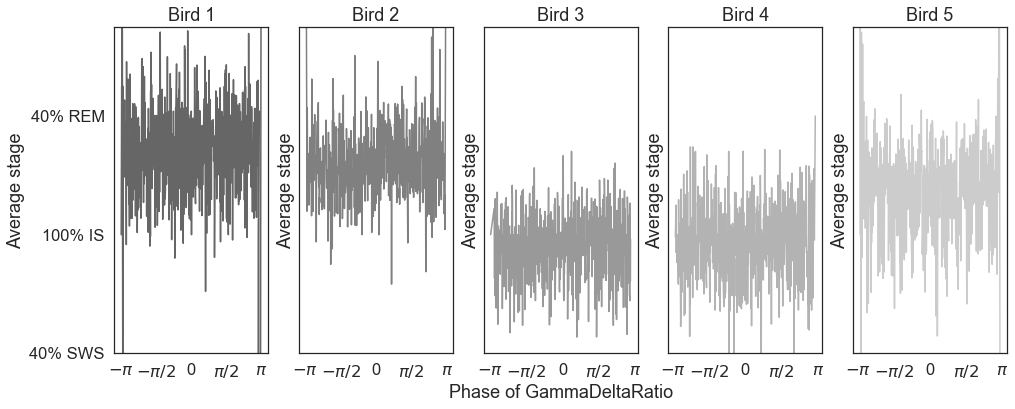

In [106]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG_best[b_num]]
    
    flipped_scores_mean = MeanScore_flipped_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(flipped_scores_mean, color=colors_birds[b_num])

    if b_num == 0:
        plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
    else:
        plt.yticks([])
    
    plt.ylim(3.6,4.7)
    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('Average stage')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = flipped_scores_mean

#if savePlots:
#    name = saveAsPath + saveAsName + 'g_mean_score_by_phase_' + variable + '_' + moving_avg + '_individuals'
#    plt.savefig(name + '.pdf')

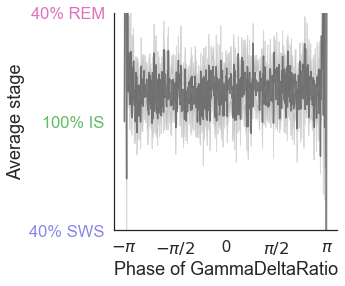

In [107]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(4,4))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=color3, alpha=alpha_main)
plt.plot(grandmean, color=color3, alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('Average stage')
plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
plt.ylim(3.6, 4.4)

flipped_colors = (colors[4], colors[3], colors[5])
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(flipped_colors, ax.yaxis.get_ticklabels())]

sns.despine()

#if savePlots:
#    name = saveAsPath + saveAsName + 'g_mean_score_by_phase_' + variable + '_' + moving_avg + '_ALL'
#    plt.savefig(name + '.pdf')

## Run on all birds: 10 s MA (DeltaLog)

In [108]:
variable = 'DeltaLog'
moving_avg = '10s_MA'
moving_avg_s = 10

# init
MeanScore_flipped_byPhase = {}
MeanPhase_byScore = {}
for bird in birds:
    print(bird)
    b_num = int(bird[5]) - 1
    
    # get channels for each bird
    all_channels = list(SleepVariables.keys())
    EEGchannels = np.sort([x for x in all_channels if bird + ': ' in x])

    # init
    bird_scores_by_phase = pd.DataFrame([])
    bird_phases_by_score = pd.DataFrame([])
    
    # Calc phases for each channel
    for ch in EEGchannels:        
        if not np.isnan(AllAutocorrPeriods_Deltalog[ch][moving_avg]):
            phases_by_epoch, fit_pd = ultradian_phase_vs_stage(ch, variable, moving_avg, moving_avg_s,
                                                              AllAutocorrPeriods=AllAutocorrPeriods_Deltalog)

            flipped_scores_mean = phases_by_epoch.groupby('Phase rounded')['sleep scores flipped'].mean()
            mean_phase_by_score = phases_by_epoch.groupby('sleep scores')['Phase'].mean()

            bird_scores_by_phase[ch] = (flipped_scores_mean)
            bird_phases_by_score[ch] = (mean_phase_by_score)
        
    # Save to dict
    MeanScore_flipped_byPhase[bird] = bird_scores_by_phase
    MeanPhase_byScore[bird]         = bird_phases_by_score


Bird 1
Bird 2
Bird 3
Bird 4
Bird 5


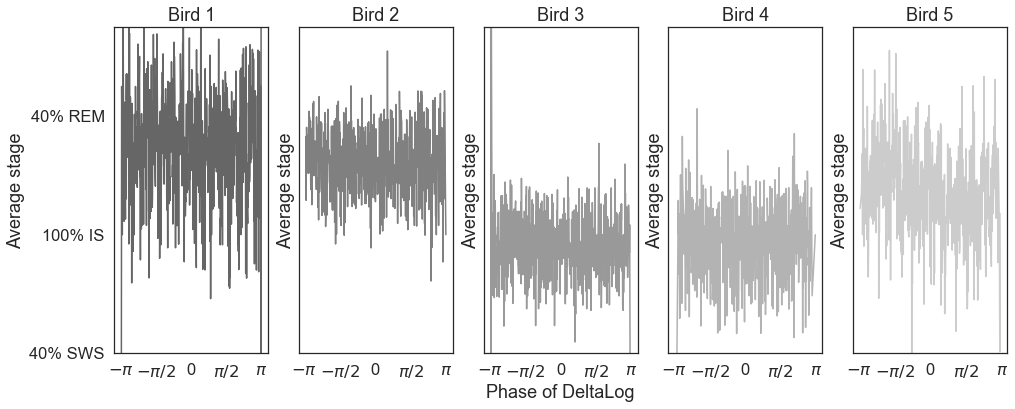

In [109]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG_best[b_num]]
    
    flipped_scores_mean = MeanScore_flipped_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(flipped_scores_mean, color=colors_birds[b_num])

    if b_num == 0:
        plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
    else:
        plt.yticks([])
    
    plt.ylim(3.6,4.7)
    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('Average stage')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = flipped_scores_mean

#if savePlots:
#    name = saveAsPath + saveAsName + '_mean_score_by_phase_' + variable + '_' + moving_avg + '_individuals'
#    plt.savefig(name + '.pdf')

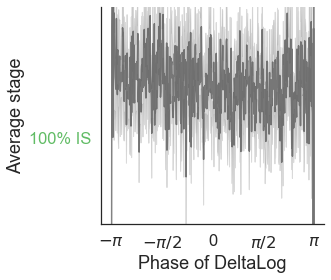

In [110]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(4,4))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=color3, alpha=alpha_main)
plt.plot(grandmean, color=color3, alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('Average stage')
plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
plt.ylim(3.8, 4.3)

flipped_colors = (colors[4], colors[3], colors[5])
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(flipped_colors, ax.yaxis.get_ticklabels())]

sns.despine()

#if savePlots:
#    name = saveAsPath + saveAsName + '_mean_score_by_phase_' + variable + '_' + moving_avg + '_ALL'
#    plt.savefig(name + '.pdf')

### Plot mean phase by score

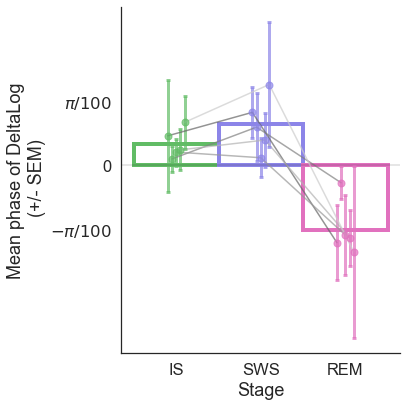

In [111]:
Means = pd.DataFrame([])
plt.figure(figsize=(6,6))

for bird in birds:
    b_num = int(bird[5]) - 1
    jitter = -.1 + b_num*.05
    
    # include all channels
    channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    
    # calculate means across channels
    mean_phase_by_score = MeanPhase_byScore[bird][channels].mean(axis=1)
    std_phase_by_score  = MeanPhase_byScore[bird][channels].std(axis=1)
    n_by_score          = MeanPhase_byScore[bird][channels].count(axis=1)
    sem_phase_by_score  = std_phase_by_score/np.sqrt(n_by_score)
    
    # lines, color-coded by bird
    plt.plot(mean_phase_by_score.index + jitter,
             mean_phase_by_score.values, 
             color=colors_birds[b_num], alpha=linealpha)
    
    # dots + errorbars, color-coded by stage
    for stage in [3,4,5]:
        plt.errorbar(stage + jitter, mean_phase_by_score[stage], yerr=sem_phase_by_score[stage],
                 marker='o',markersize=7, color=colors[stage], 
                        alpha=0.7, capsize=2, capthick=3, elinewidth=3)

    plt.xlabel('Stage')
    plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
    plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
    plt.axhline(0, color='k', alpha=.025)
    
    # Save mean to dataframe
    Means[bird] = mean_phase_by_score
    

# Bar graph of means
for stage in [3,4,5]:
    plt.bar(stage, Means.mean(axis=1)[stage], width=1, color='none', edgecolor=colors[stage], linewidth=bar_linewidth)

plt.yticks([-np.pi/100, 0, np.pi/100], ['$-\pi/100$', '0', '$\pi/100$']);

sns.despine()
plt.tight_layout()

#if savePlots:
#    name = saveAsPath + saveAsName + '_mean_phase_by_score_' + variable + '_' + moving_avg + '_SEMs'
#    plt.savefig(name + '.pdf')

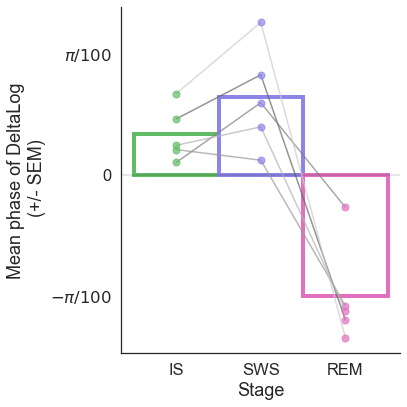

In [112]:
Means = pd.DataFrame([])
plt.figure(figsize=(6,6))

for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include all channels
    channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    
    # calculate means across channels
    mean_phase_by_score = MeanPhase_byScore[bird][channels].mean(axis=1)
    std_phase_by_score  = MeanPhase_byScore[bird][channels].std(axis=1)
    n_by_score          = MeanPhase_byScore[bird][channels].count(axis=1)
    sem_phase_by_score  = std_phase_by_score/np.sqrt(n_by_score)
    
    # lines, color-coded by bird
    plt.plot(mean_phase_by_score.index,
             mean_phase_by_score.values, 
             color=colors_birds[b_num], alpha=linealpha)
    
    # dots + errorbars, color-coded by stage
    for stage in [3,4,5]:
        plt.plot(stage, mean_phase_by_score[stage], 
                 marker='o',markersize=7, color=colors[stage], 
                 alpha=0.7)

    plt.xlabel('Stage')
    plt.ylabel('Mean phase of ' + variable + '\n (+/- SEM)')
    plt.xticks([3,4,5], ['IS', 'SWS', 'REM'])
    plt.axhline(0, color='k', alpha=.025)
    
    # Save mean to dataframe
    Means[bird] = mean_phase_by_score
    

# Bar graph of means
for stage in [3,4,5]:
    plt.bar(stage, Means.mean(axis=1)[stage], width=1, color='none', edgecolor=colors[stage], linewidth=bar_linewidth)

plt.yticks([-np.pi/100, 0, np.pi/100], ['$-\pi/100$', '0', '$\pi/100$']);

sns.despine()
plt.tight_layout()

#if savePlots:
#    name = saveAsPath + saveAsName + '_mean_phase_by_score_' + variable + '_' + moving_avg
#    plt.savefig(name + '.pdf')

### Plot mean score by phase

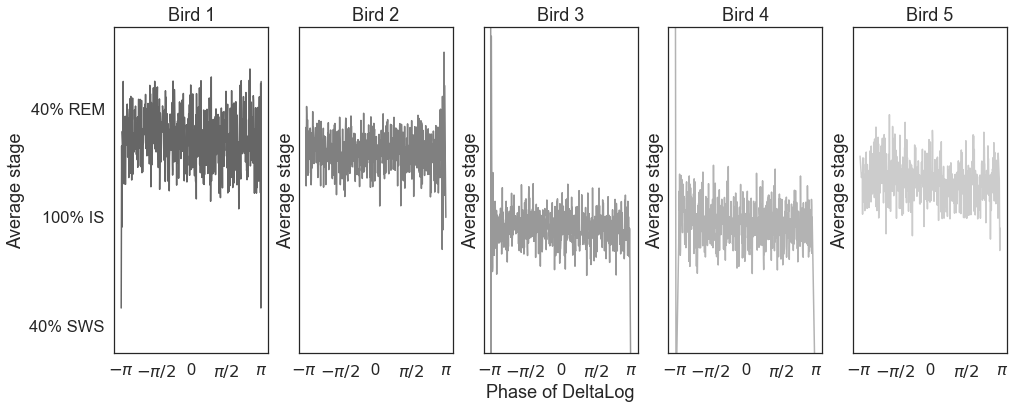

In [113]:
Means = pd.DataFrame([])

plt.figure(figsize=figsize)
for bird in birds:
    b_num = int(bird[5]) - 1
    
    # include best channels only
    channels = [bird+': '+x for x in channelsToLoadEEG[b_num]]
    
    flipped_scores_mean = MeanScore_flipped_byPhase[bird][channels].mean(axis=1)

    plt.subplot(1,5, b_num+1)

    plt.plot(flipped_scores_mean, color=colors_birds[b_num])

    if b_num == 0:
        plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
    else:
        plt.yticks([])
    
    plt.ylim(3.5,4.7)
    plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
               ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);
    plt.ylabel('Average stage')
    plt.title(bird)
    
    if b_num == 2:
        plt.xlabel('Phase of ' + variable)
    
    Means[bird] = flipped_scores_mean

#if savePlots:
#    name = saveAsPath + saveAsName + '_mean_score_by_phase_' + variable + '_' + moving_avg + '_individuals'
#    plt.savefig(name + '.pdf')

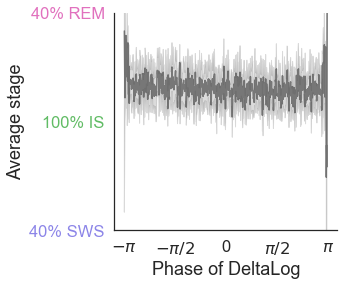

In [114]:
grandmean = Means.mean(axis=1)
grand_SD  = Means.std(axis=1)
counts    = Means.count(axis=1)
grand_SEMs= grand_SD/np.sqrt(counts)

plt.figure(figsize=(4,4))

plt.fill_between(grandmean.index, grandmean - grand_SEMs, grandmean + grand_SEMs,
                color=color3, alpha=alpha_main)
plt.plot(grandmean, color=color3, alpha=.7)


plt.xlabel('Phase of ' + variable)
plt.xticks(np.arange(-np.pi, np.pi + .1, np.pi/2),
           ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$']);

plt.ylabel('Average stage')
plt.yticks([3.6, 4, 4.4], ['40% SWS', '100% IS', '40% REM']);
plt.ylim(3.6, 4.4)

flipped_colors = (colors[4], colors[3], colors[5])
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(flipped_colors, ax.yaxis.get_ticklabels())]

sns.despine()

#if savePlots:
#    name = saveAsPath + saveAsName + '_mean_score_by_phase_' + variable + '_' + moving_avg + '_ALL'
#    plt.savefig(name + '.pdf')